In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
import statsmodels.api as sm
import numpy as np
import yfinance as yf
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Final Project: S&P500 Prediction
## Introduction


This project explores the integration and enhancement of US Macro and Yahoo Finance datasets to analyze economic and financial trends. The data preprocessing involved addressing inconsistencies due to missing dates, such as weekends and holidays, by backfilling stock market data. This process yielded a complete dataset with 222 observations. Extensive feature engineering, including log transformations of time-series variables, was employed to improve the model's performance. A correlation matrix and variable distribution analysis informed the selection and refinement of features. Challenges such as outlier management and the significant impact of the COVID-19 pandemic on economic patterns were identified as critical factors affecting model accuracy. The project underscores the importance of robust data cleaning, thoughtful feature engineering, and external event consideration in predictive modeling for macroeconomic and financial datasets.



## Introduction

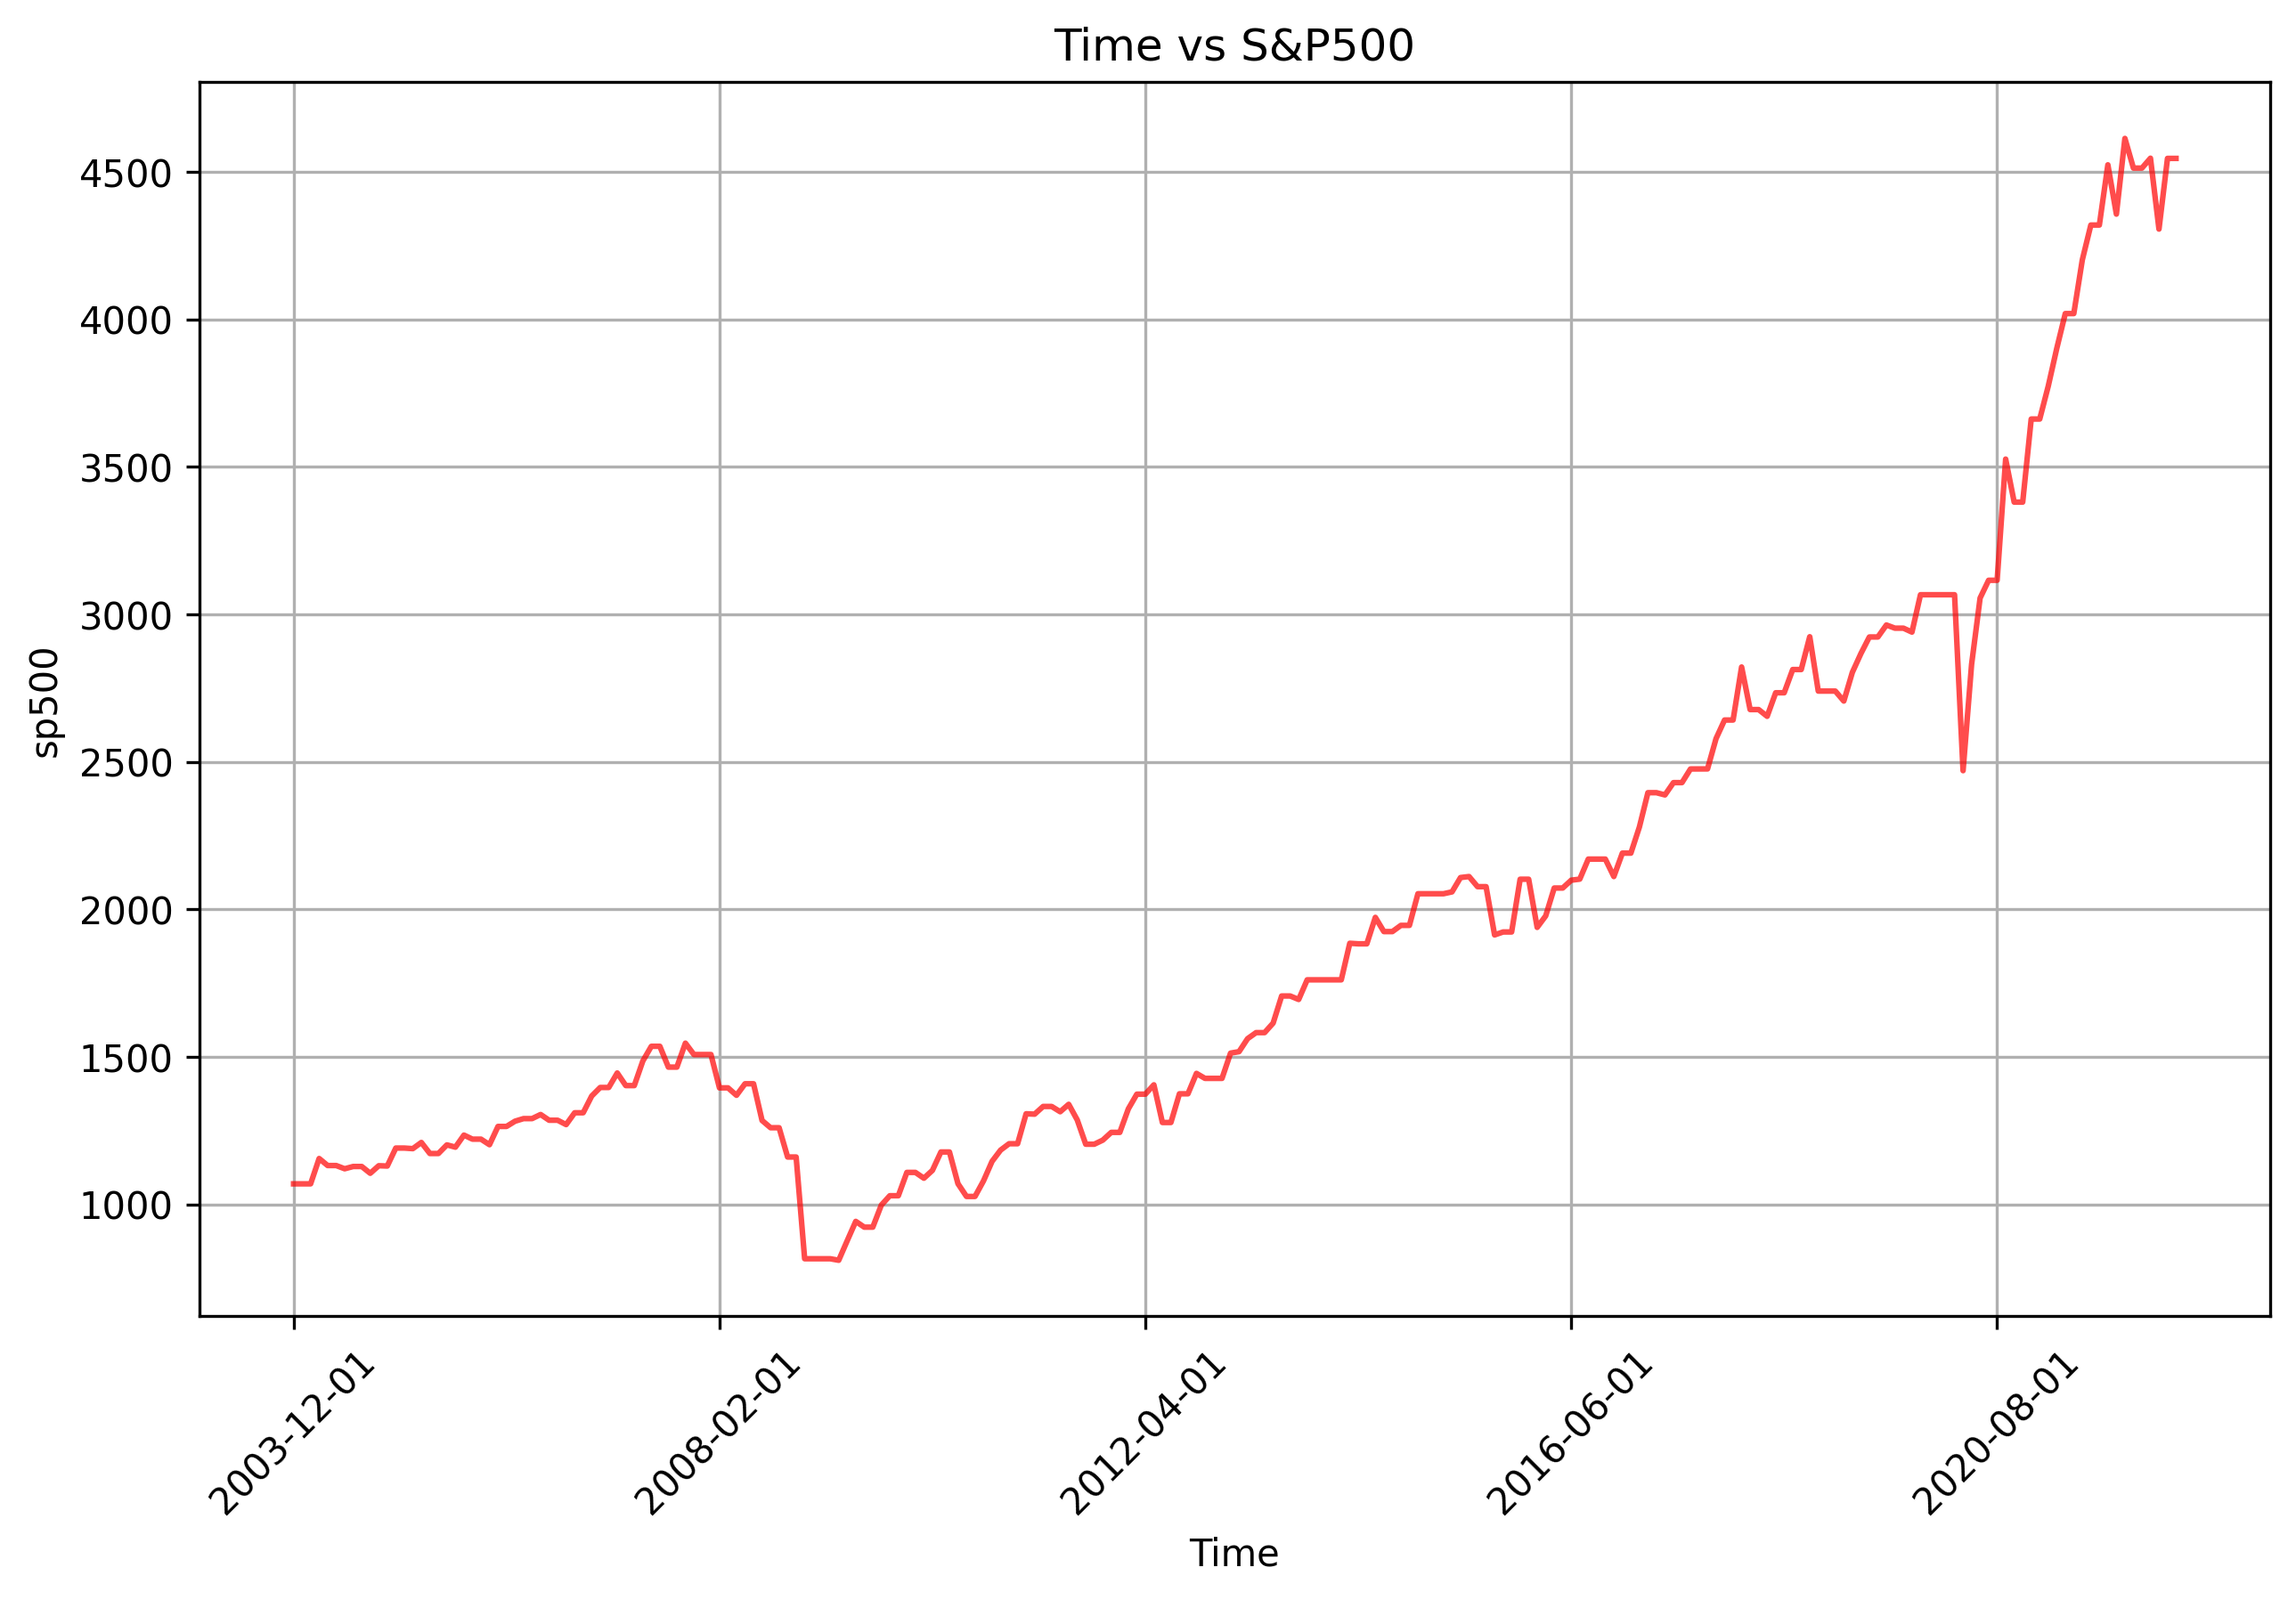

The S&P 500 index, which represents the performance of 500 top firms, is a crucial benchmark for the American stock market and the overall economy. For investors, financial institutions, and policymakers to manage risks, make informed judgements, and fully understand economic patterns, they must be able to predict its movements. However, precise forecasting is difficult because to the index's complexity, which is influenced by factors such as world events, corporate performance, and macroeconomic conditions.

The goal of this research is to develop a model that predicts the S&P 500 by combining financial data from Yahoo Finance with macroeconomic variables. These datasets offer a thorough basis for study by capturing both broad economic trends and specific market activities. We cleaned and analysed the data to improve reliability in order to address issues like missing data from market closures. Feature engineering, including transformations of time-series data, was applied to enhance predictive power.

Additional difficulties were brought about by COVID-19's effect on markets, underscoring the necessity of modifying models to take unforeseen shocks into account. This research seeks to provide a useful, data-driven method for S&P 500 prediction by fusing statistical methods with machine learning. The findings will serve to demonstrate how careful analysis might facilitate better financial decisions in a market that is changing quickly.


## Data description

This project utilizes two primary datasets: macroeconomic indicators from US economic data and stock market data from Yahoo Finance. Together, these datasets provide a comprehensive view of the factors influencing the S&P 500 index.

The macroeconomic dataset includes key indicators such as GDP growth, unemployment rates, inflation, and interest rates. These metrics are essential for capturing the broader economic context in which the stock market operates. Since macroeconomic data is often reported on a monthly or quarterly basis, we ensured proper alignment with the daily frequency of the stock market data through  backfilling.

We have collected data from Yahoo Finance to supplement our US Macro dataset. As there was a mismatch of dates between the datasets due to some Macro data being reported on the weekends where there was no stock market closing prices, I backfilled the closing price from the previous Friday for all stock market data on the weekends/bank holidays. This gave me a complete dataset which I then subsequently removed Nan values from to give us a completed dataset with 222 observations.

Both datasets were subjected to feature engineering in order to enhance predictive performance. To stabilise variability and draw attention to significant patterns, transformations were used, such as taking the time-series variables' first difference. Distribution plots and a correlation matrix were used to identify important factors and outliers in the data which needed to be dealt with.

Additionally, the impact of external events, such as the COVID-19 pandemic, was considered. Significant outliers and data variations were brought about by these disruptions, necessitating careful handling to avoid bias in model predictions. To preserve the quality of the data, outlier detection and adjustment techniques were used.

222 observations with characteristics from the financial and economic domains make up the combined dataset in its entirety. Developing precise and perceptive predictive models is made possible by this cohesive dataset, which offers a strong basis for investigating the connections between macroeconomic indicators and the S&P 500 index.



In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Hardmanwr/foundations_of_data_science/refs/heads/main/US_macroeconomics.csv")
data = data.set_index('date')

sp500 = yf.download("^GSPC")
sp500.index = pd.to_datetime(sp500.index)
sp500.index = sp500.index.strftime('%Y-%m-%d')

data["sp500"] = sp500["Close"]
data['sp500'] = data['sp500'].ffill()

ticker = "^TNX"
interest = yf.download(ticker)
data["base rate"] = interest["Close"]
data['base rate'] = data['base rate'].ffill()

oil_ticker = "CL=F"
oil = yf.download(oil_ticker)
data["oil"] = oil["Close"]
data['oil'] = data['oil'].ffill()
gold_ticker = "GC=F"
gold = yf.download(gold_ticker)
data["gold"] = gold["Close"]
data['gold'] = data['gold'].ffill()

currencies = ["USDGBP=X", "USDEUR=X", "USDJPY=X"]

forex = pd.DataFrame()
for pairs in currencies:
    forex[pairs] = yf.download(pairs)["Close"]

for currency in currencies:
    data[currency] = forex[currency]
    data[currency] = data[currency].ffill()

data = data.dropna()
data.to_csv('forex.csv', index=False)
data.shape

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(222, 14)

We start by graphing our data to better understand it:

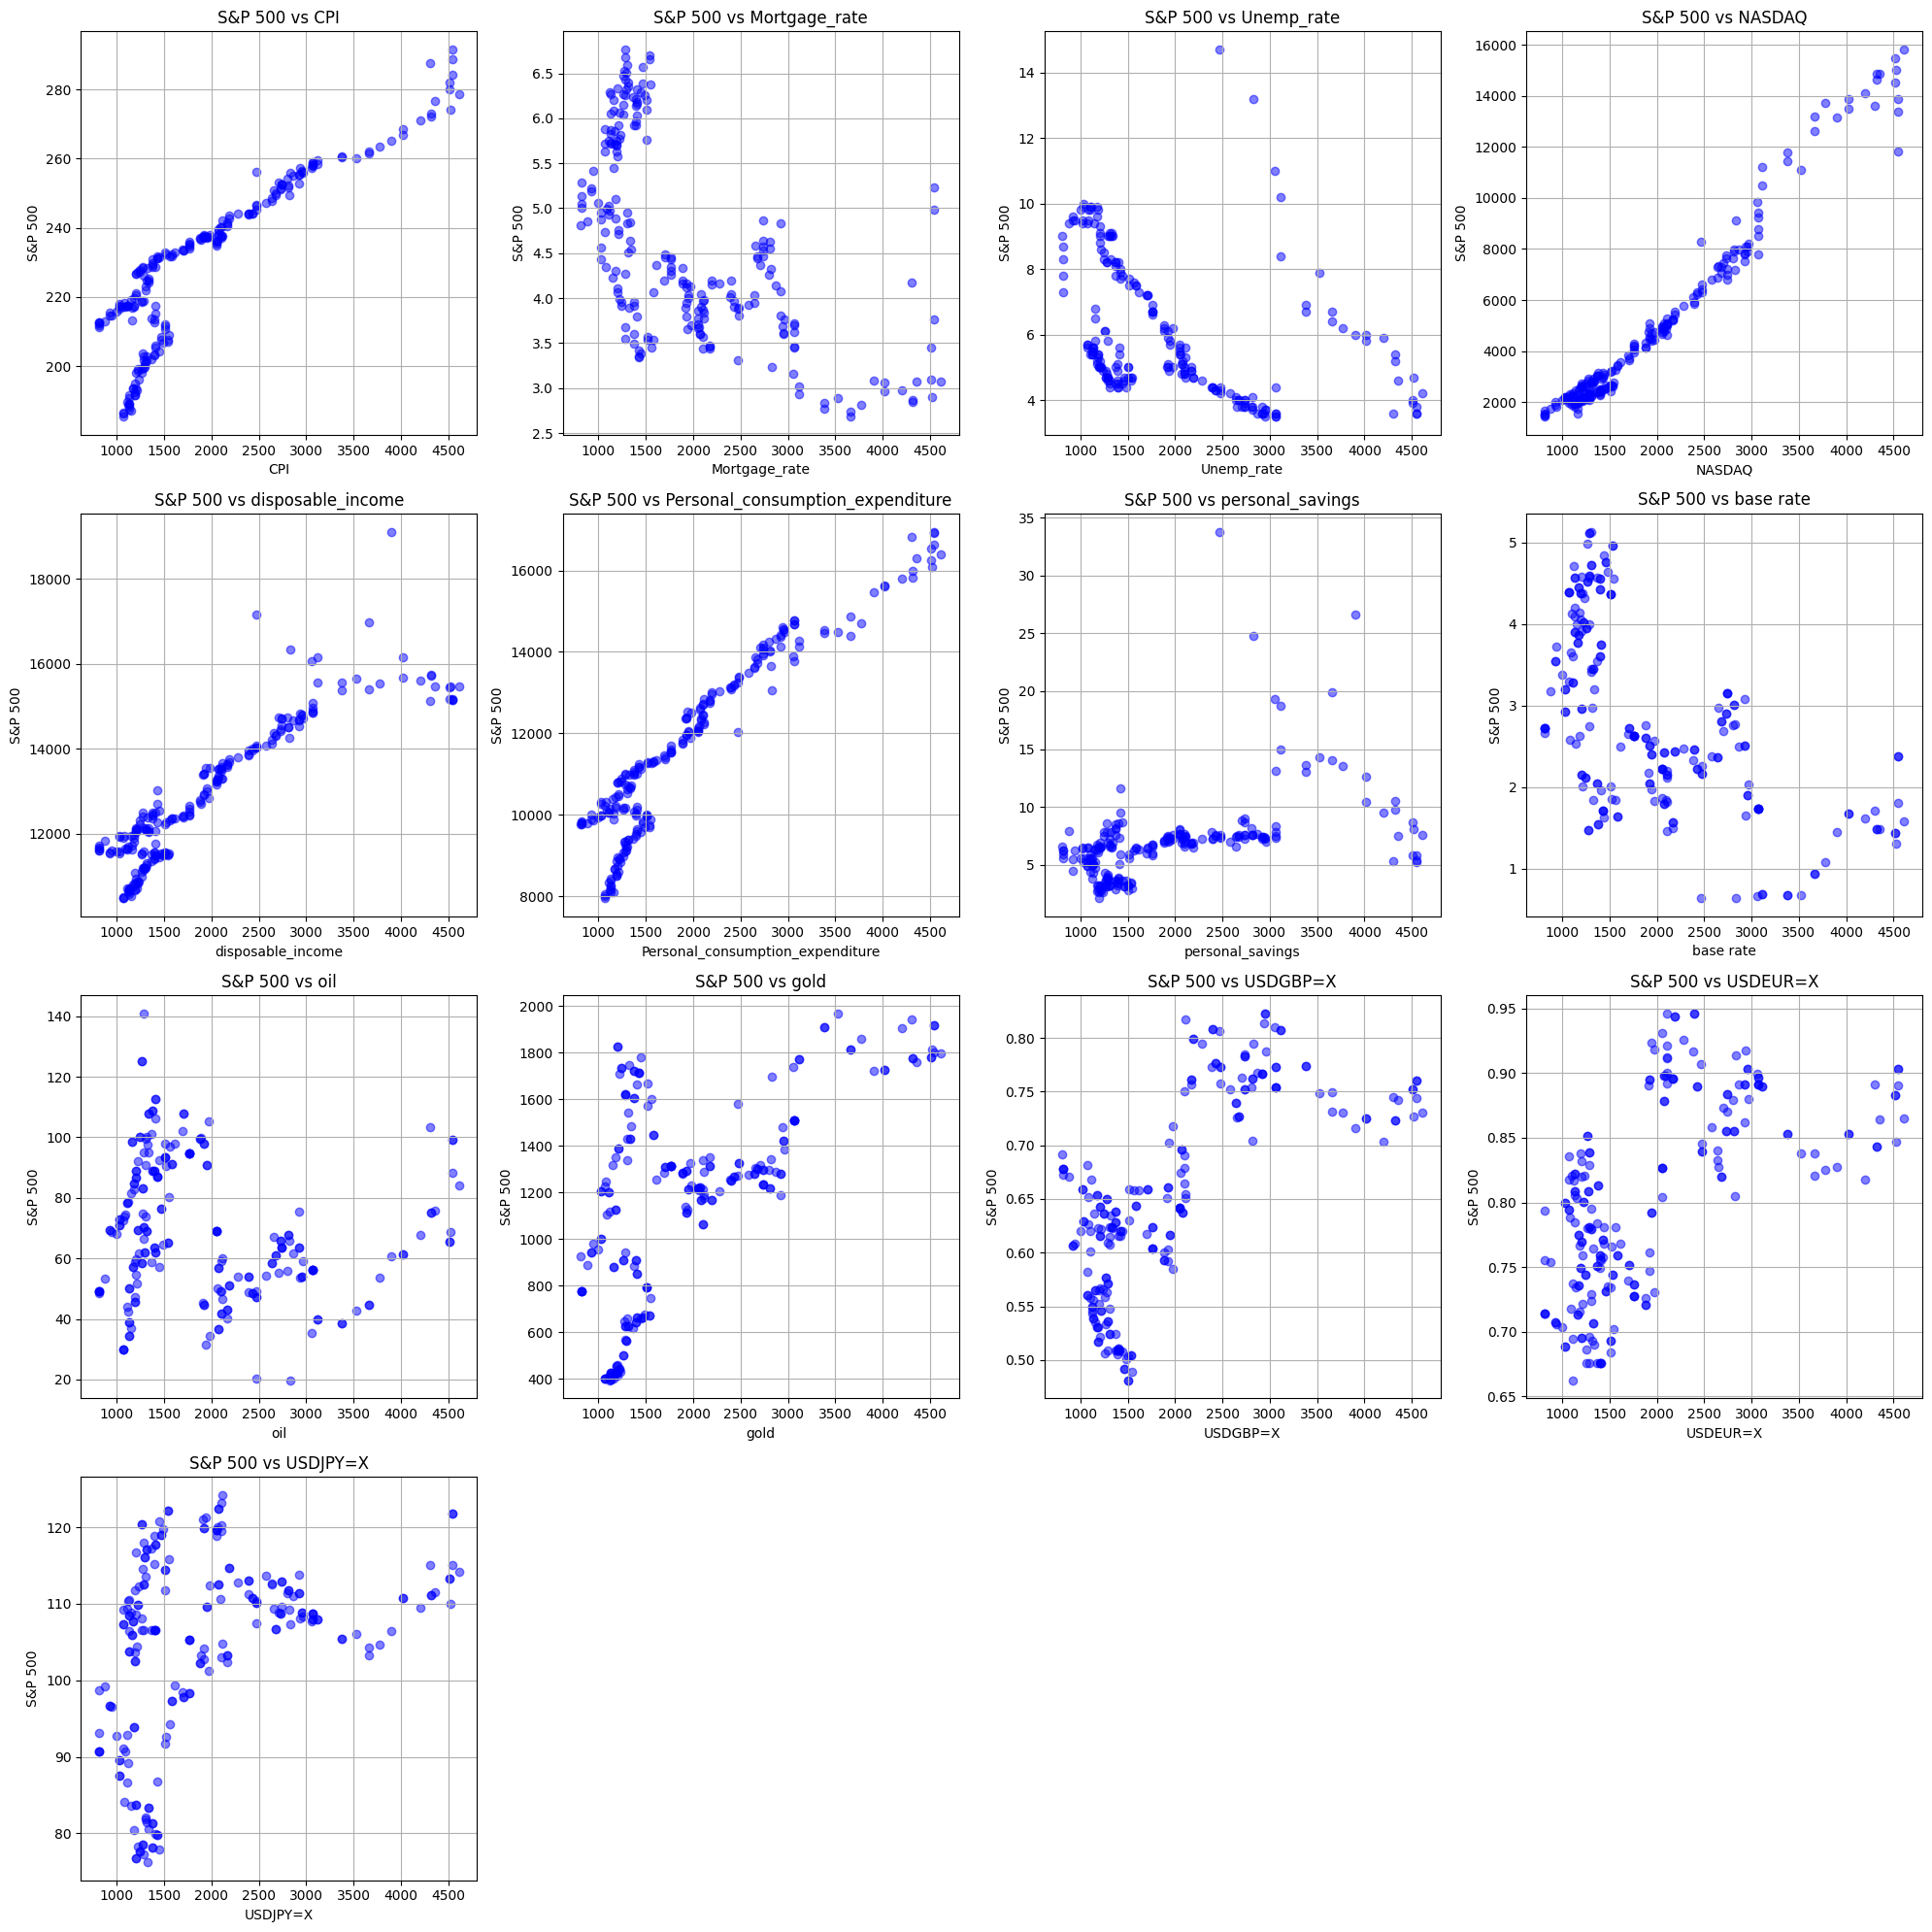

In [ ]:
save_dir = 'plots'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n_rows, n_cols = 4, 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()


columns = [col for col in data.columns if col != 'sp500']
for i, column in enumerate(columns):
    ax = axes[i]
    ax.scatter(data['sp500'], data[column], color='b', alpha=0.5)
    ax.set_xlabel(column)
    ax.set_ylabel('S&P 500')
    ax.set_title(f'S&P 500 vs {column}')
    ax.grid(True)

filename = os.path.join(save_dir, 'sp500_vs_all.png')
fig.savefig(filename, dpi=300, bbox_inches='tight')

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We want to check for non stationarity and therefore look at the time series graphs:

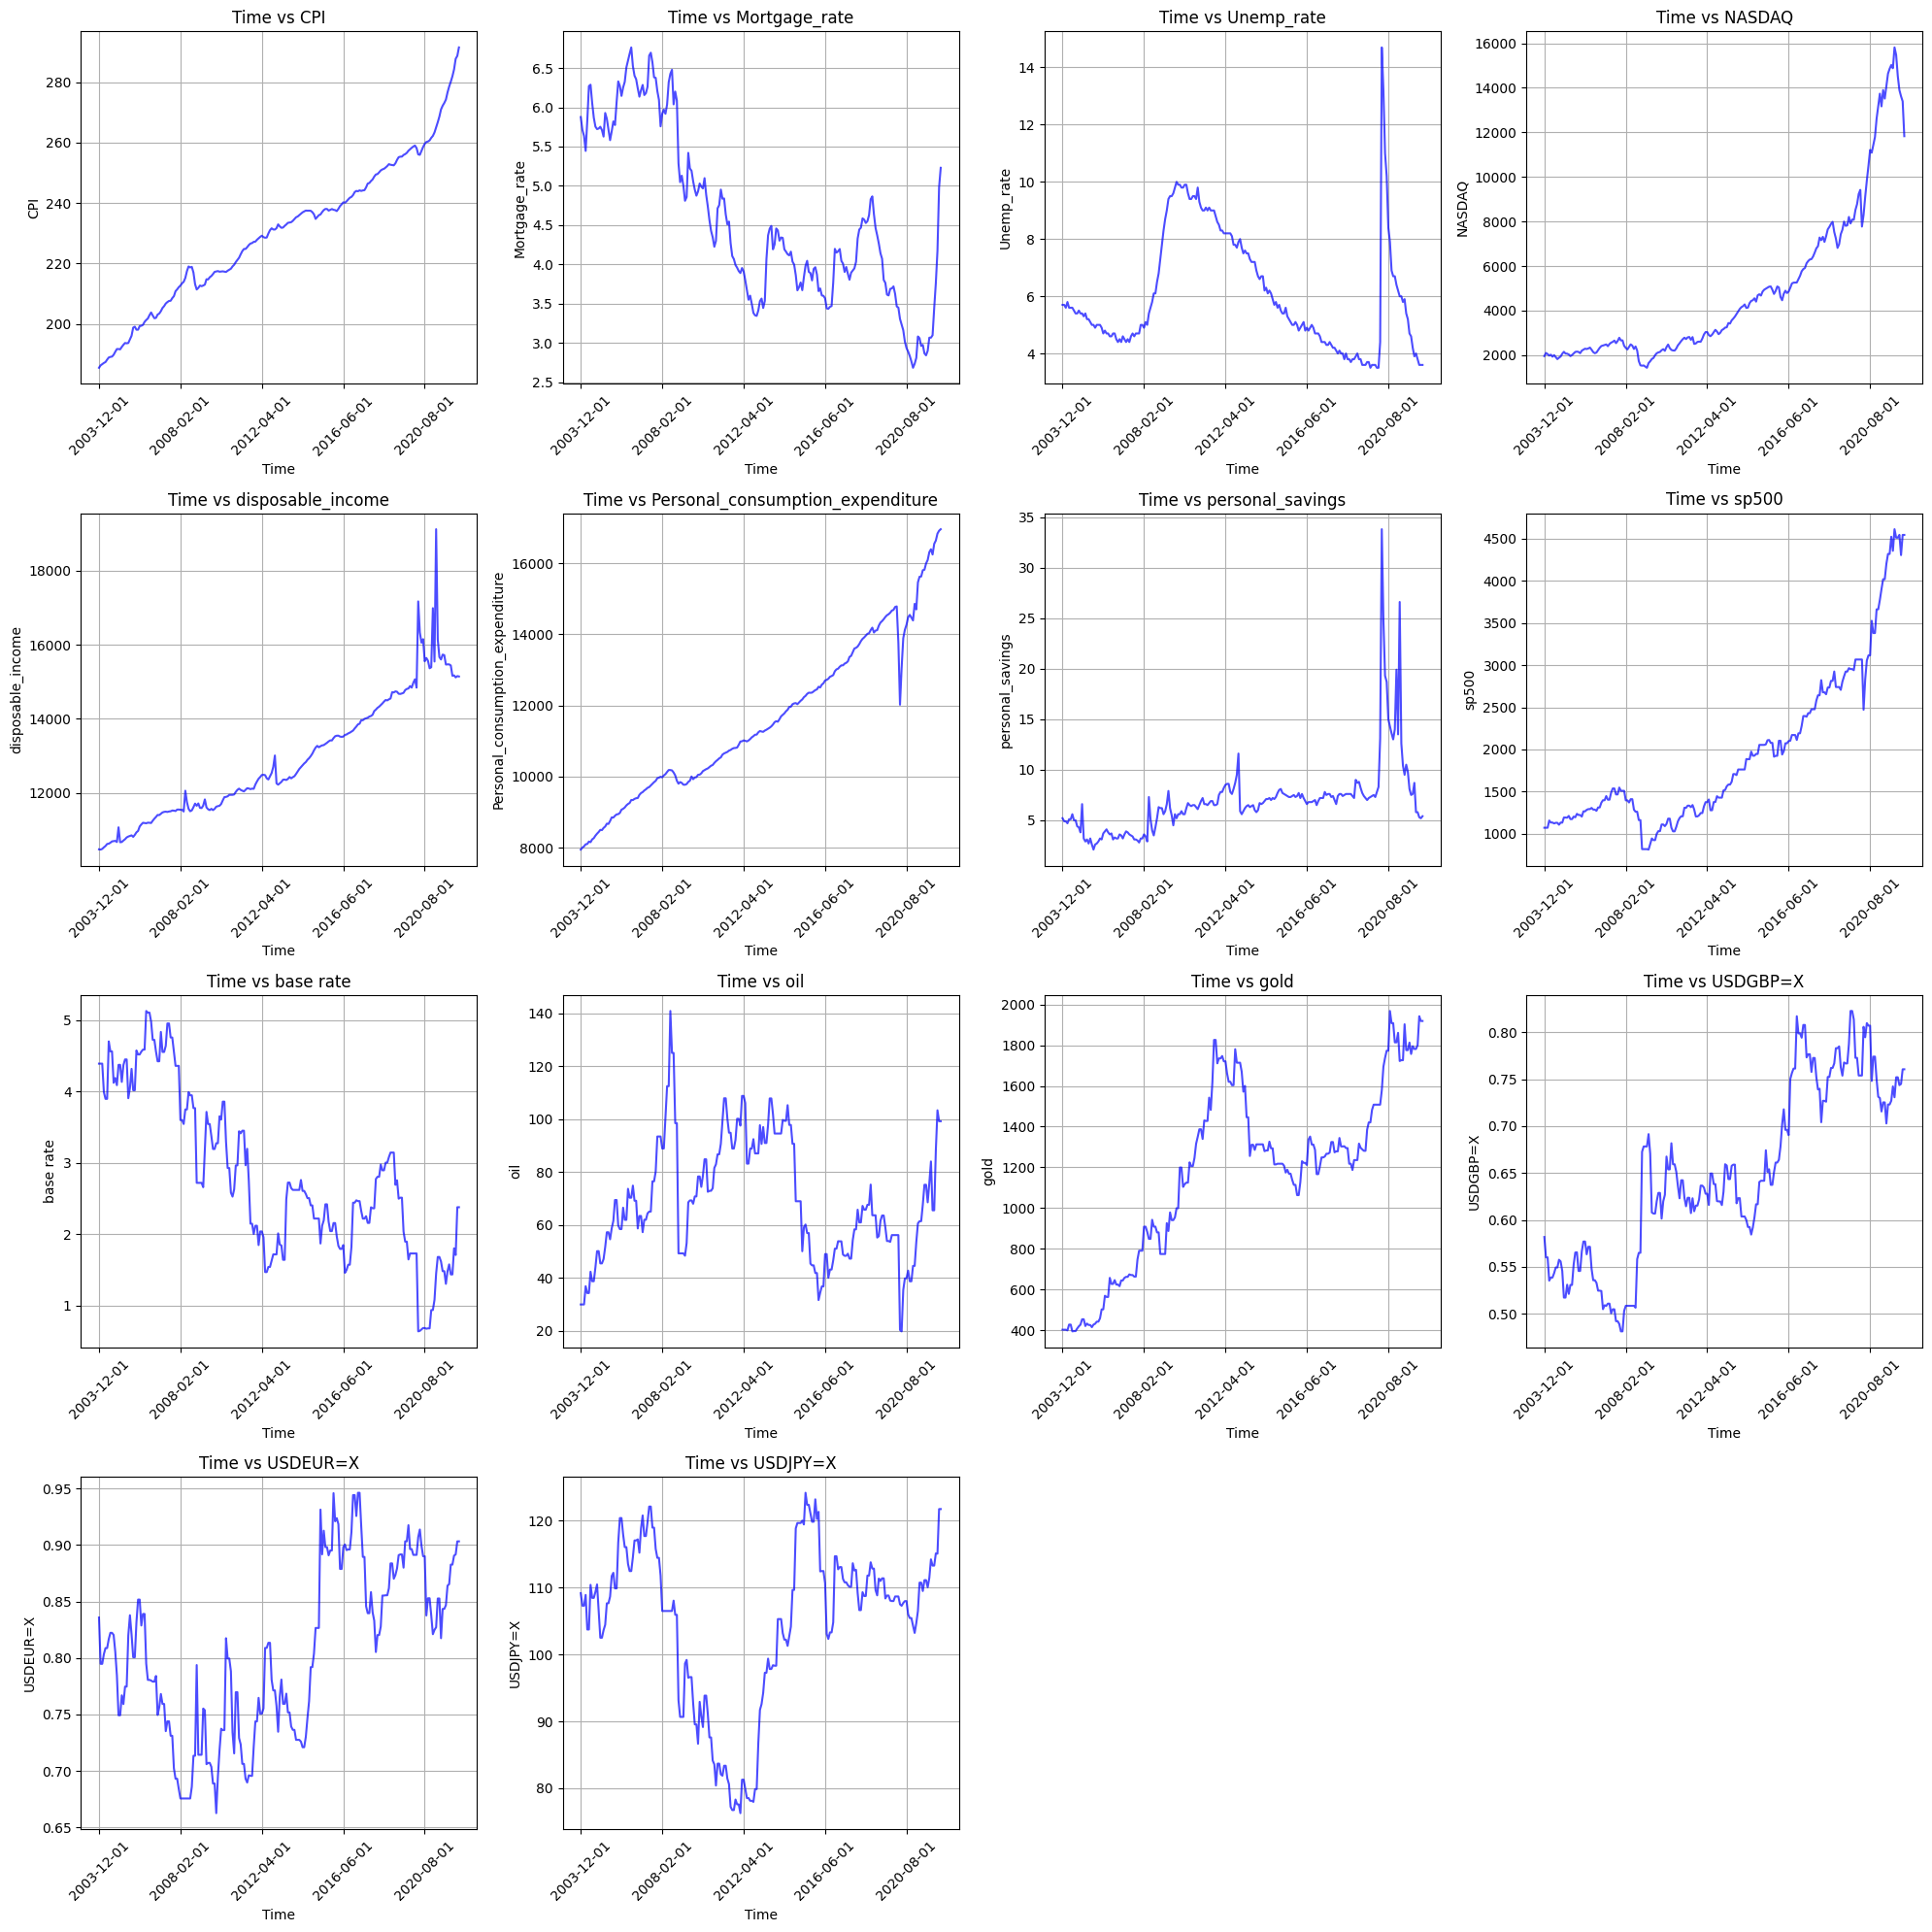

In [ ]:
save_dir = 'plots'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n_rows, n_cols = 4, 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

# Plot and save S&P500 vs Time separately
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["sp500"], color='r', alpha=0.7)
plt.xlabel('Time')
plt.ylabel("sp500")
plt.title('Time vs S&P500')
plt.grid(True)
plt.xticks(ticks=data.index[::50], rotation=45)
filename_sp500 = os.path.join(save_dir, 'time_vs_sp500.png')
plt.savefig(filename_sp500, dpi=300, bbox_inches='tight')
plt.close()

# Plot and save all other columns vs Time in a combined graph
for i, column in enumerate(data.columns):
        ax = axes[i]
        ax.plot(data.index, data[column], color='b', alpha=0.7)
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.set_title(f'Time vs {column}')
        ax.grid(True)
        ax.set_xticks(data.index[::50])
        ax.tick_params(axis='x', rotation=45)

for j in range(len(data.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Feature Engineering

We are going to do some feature engineering on independent variables. We took first differences on various variables because they are time series and the Augmented Dicky Fuller indicated evidence of non-stationarity; taking differences will assist us in distinguishing links between variables from the trend.


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {'ADF Statistic': result[0], 'p-value': result[1]}

# Apply ADF test to all numeric columns in the 'data' DataFrame
adf_results = {}
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    adf_results[column] = adf_test(data[column])

# Organize results into a DataFrame
adf_results_df = pd.DataFrame(adf_results).T
adf_results_df.columns = ['ADF Statistic', 'p-value']

# Identify non-stationary columns (p-value > 0.05)
non_stationary_cols = adf_results_df[adf_results_df['p-value'] > 0.05].index.tolist()

# Difference the non-stationary columns
for col in non_stationary_cols:
    data[col] = data[col].diff()

# Drop NaN rows generated by differencing
data = data.dropna()

# Display the ADF test results
print("ADF Test Results:")
print(adf_results_df)

# Display the first few rows of the updated data
print("\nUpdated Data with Differenced Variables:")
print(data.head())

ADF Test Results:
                                  ADF Statistic   p-value
CPI                                    1.898024  0.998525
Mortgage_rate                         -1.701283  0.430451
Unemp_rate                            -2.612122  0.090518
NASDAQ                                -0.704094  0.845686
disposable_income                     -0.141431  0.945152
Personal_consumption_expenditure       1.387180  0.997055
personal_savings                      -2.748247  0.066055
sp500                                  2.463244  0.999037
base rate                             -1.862179  0.350057
oil                                   -2.737794  0.067724
gold                                  -1.012971  0.748504
USDGBP=X                              -1.259446  0.647516
USDEUR=X                              -1.934689  0.315922
USDJPY=X                              -1.466687  0.549922

Updated Data with Differenced Variables:
            CPI  Mortgage_rate  Unemp_rate      NASDAQ  disposable_inc

We check if the data is now stationary.

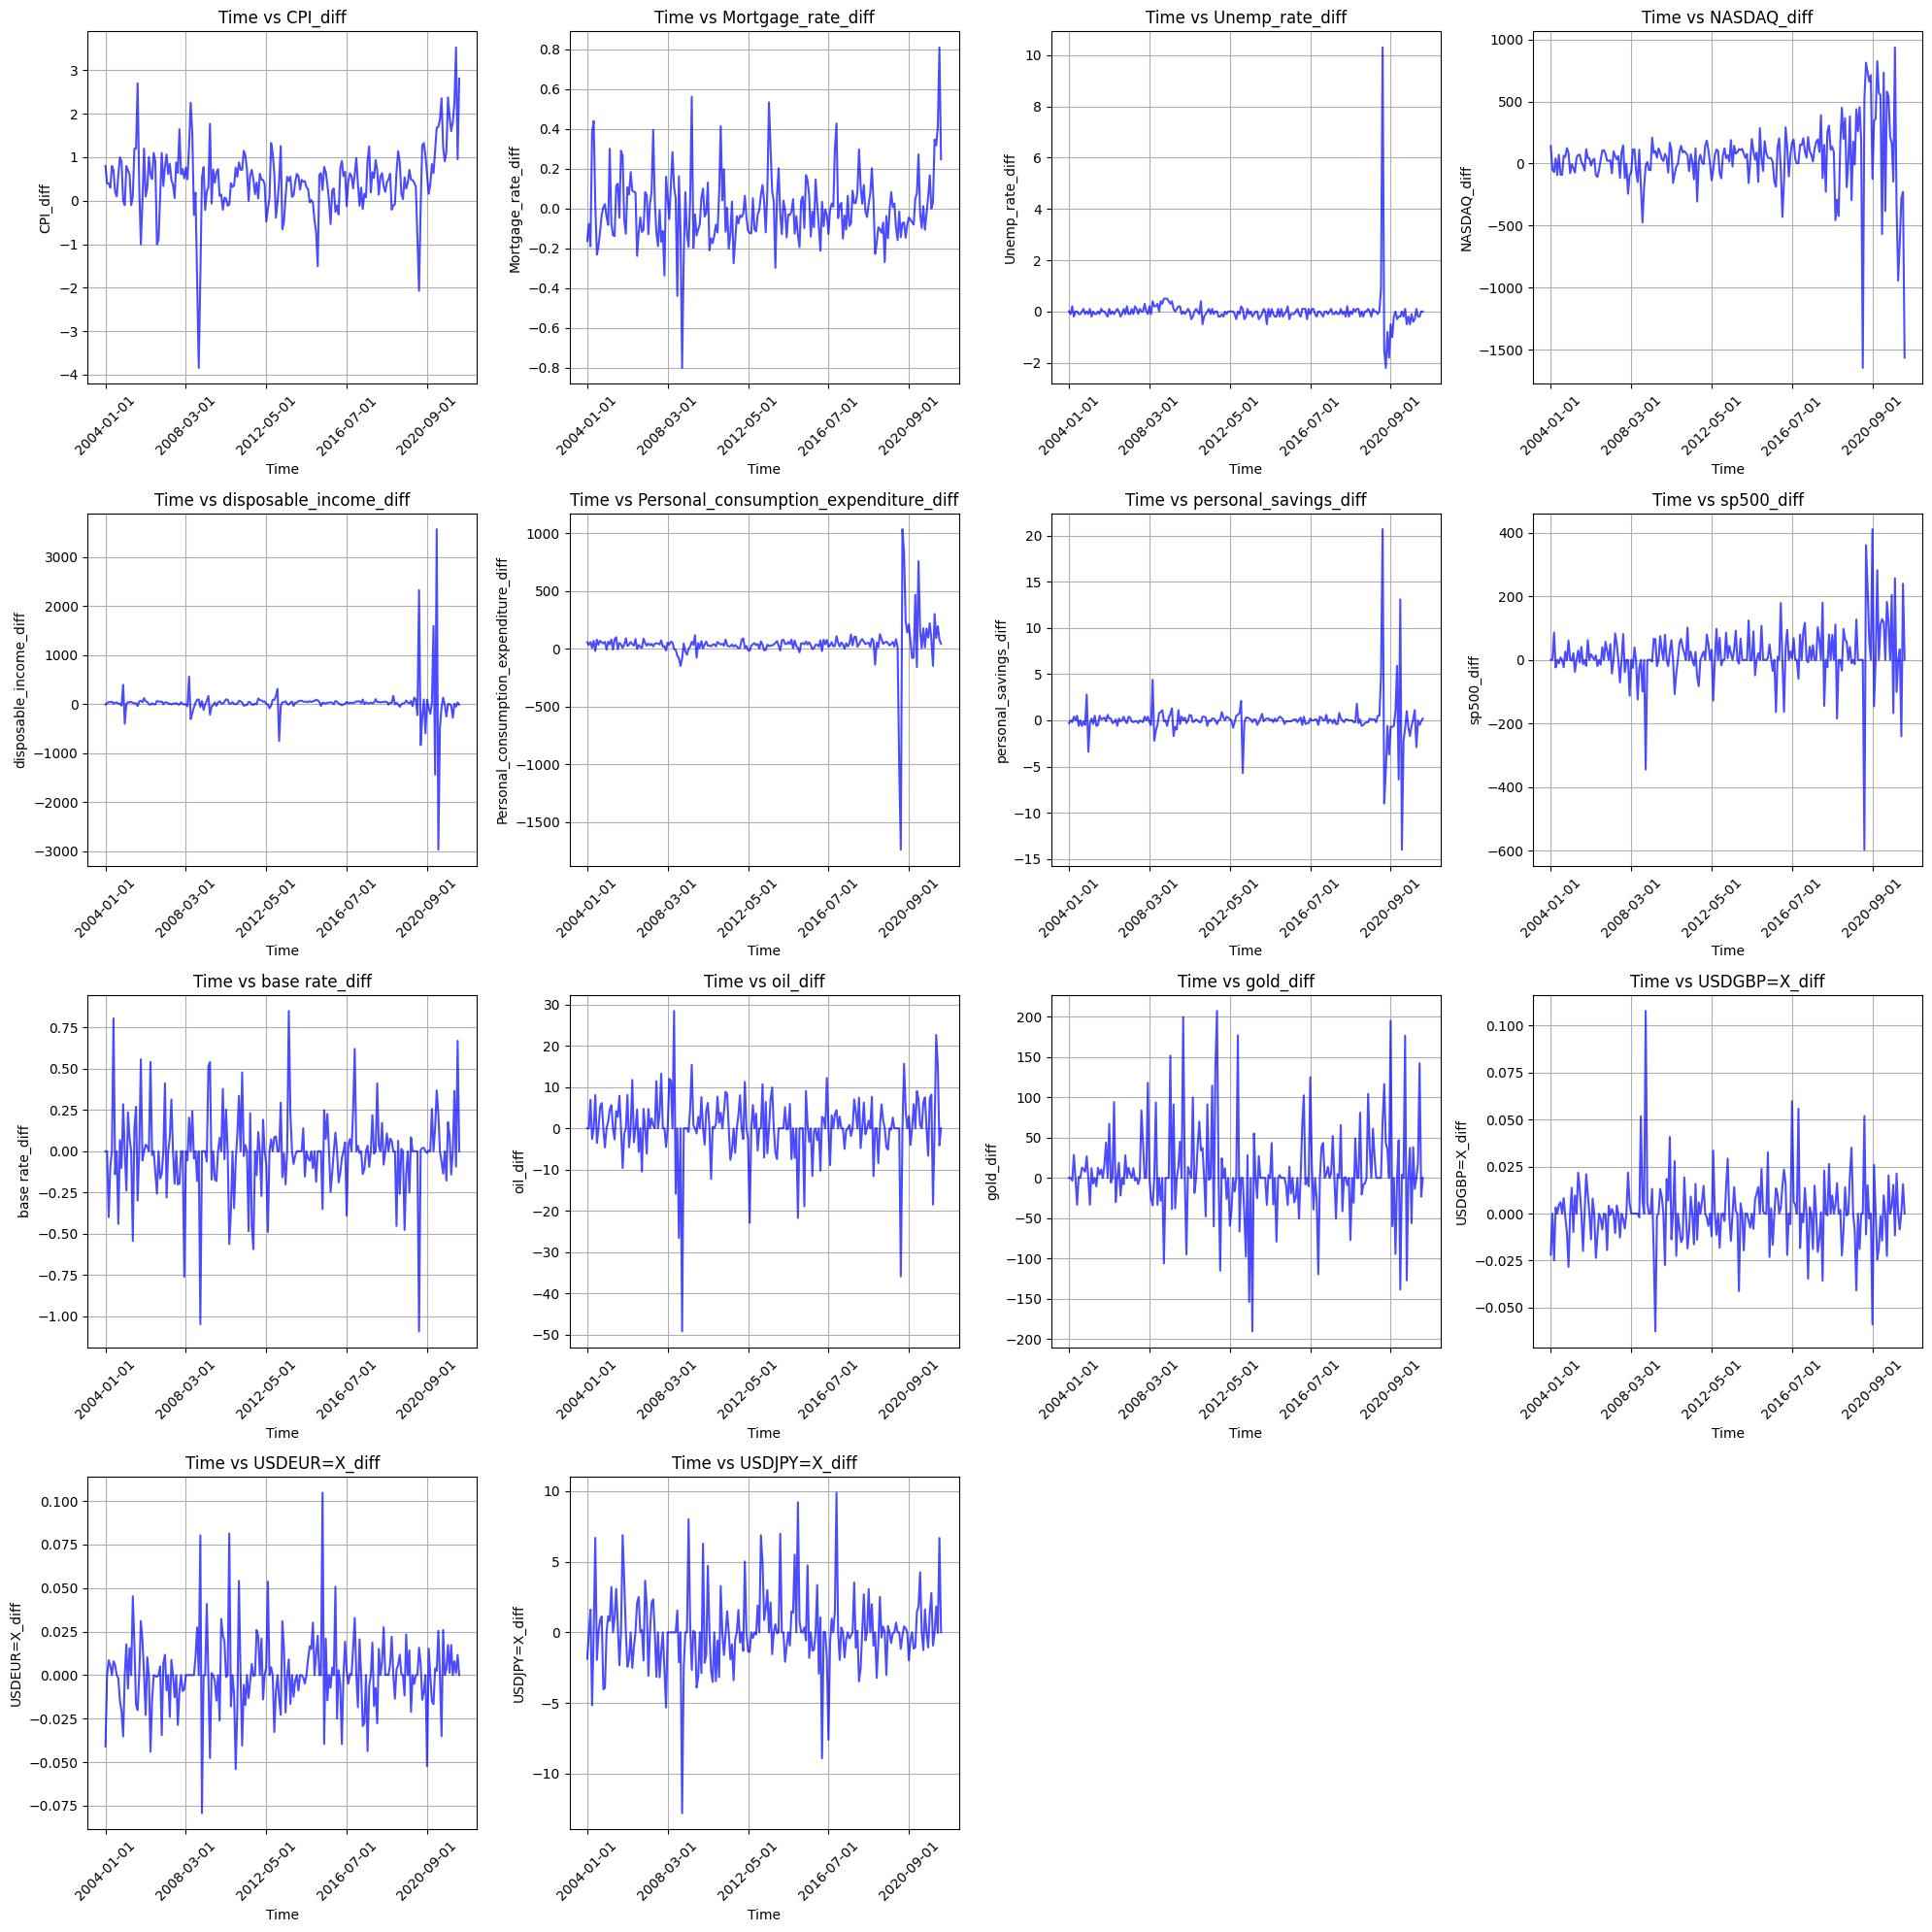

In [ ]:
save_dir = 'plots'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n_rows, n_cols = 4, 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]
    ax.plot(data.index, data[column], color='b', alpha=0.7)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{column}_diff')
    ax.set_title(f'Time vs {column}_diff')
    ax.grid(True)
    ax.set_xticks(data.index[::50])
    ax.tick_params(axis='x', rotation=45)

filename = os.path.join(save_dir, 'time_vs_all_diff.png')
fig.savefig(filename, dpi=300, bbox_inches='tight')

for j in range(len(data.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

data.to_csv('forex_diff.csv', index=False)

These made us believe that COVID-19 had a big impact on some of the variables and therefore would impact the models and so we restricted observations to pre-2020. Also making a copy of the dataset with all observations for later comparison.

In [ ]:
all_data = data.copy()
data = data[data.index < '2020-01-01']

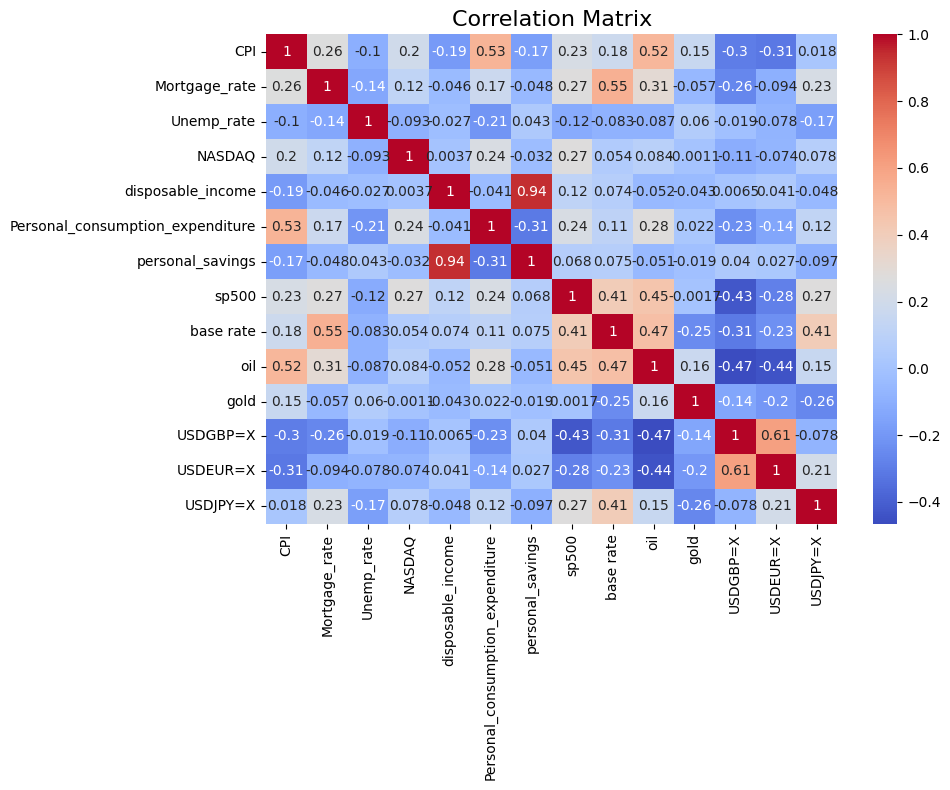

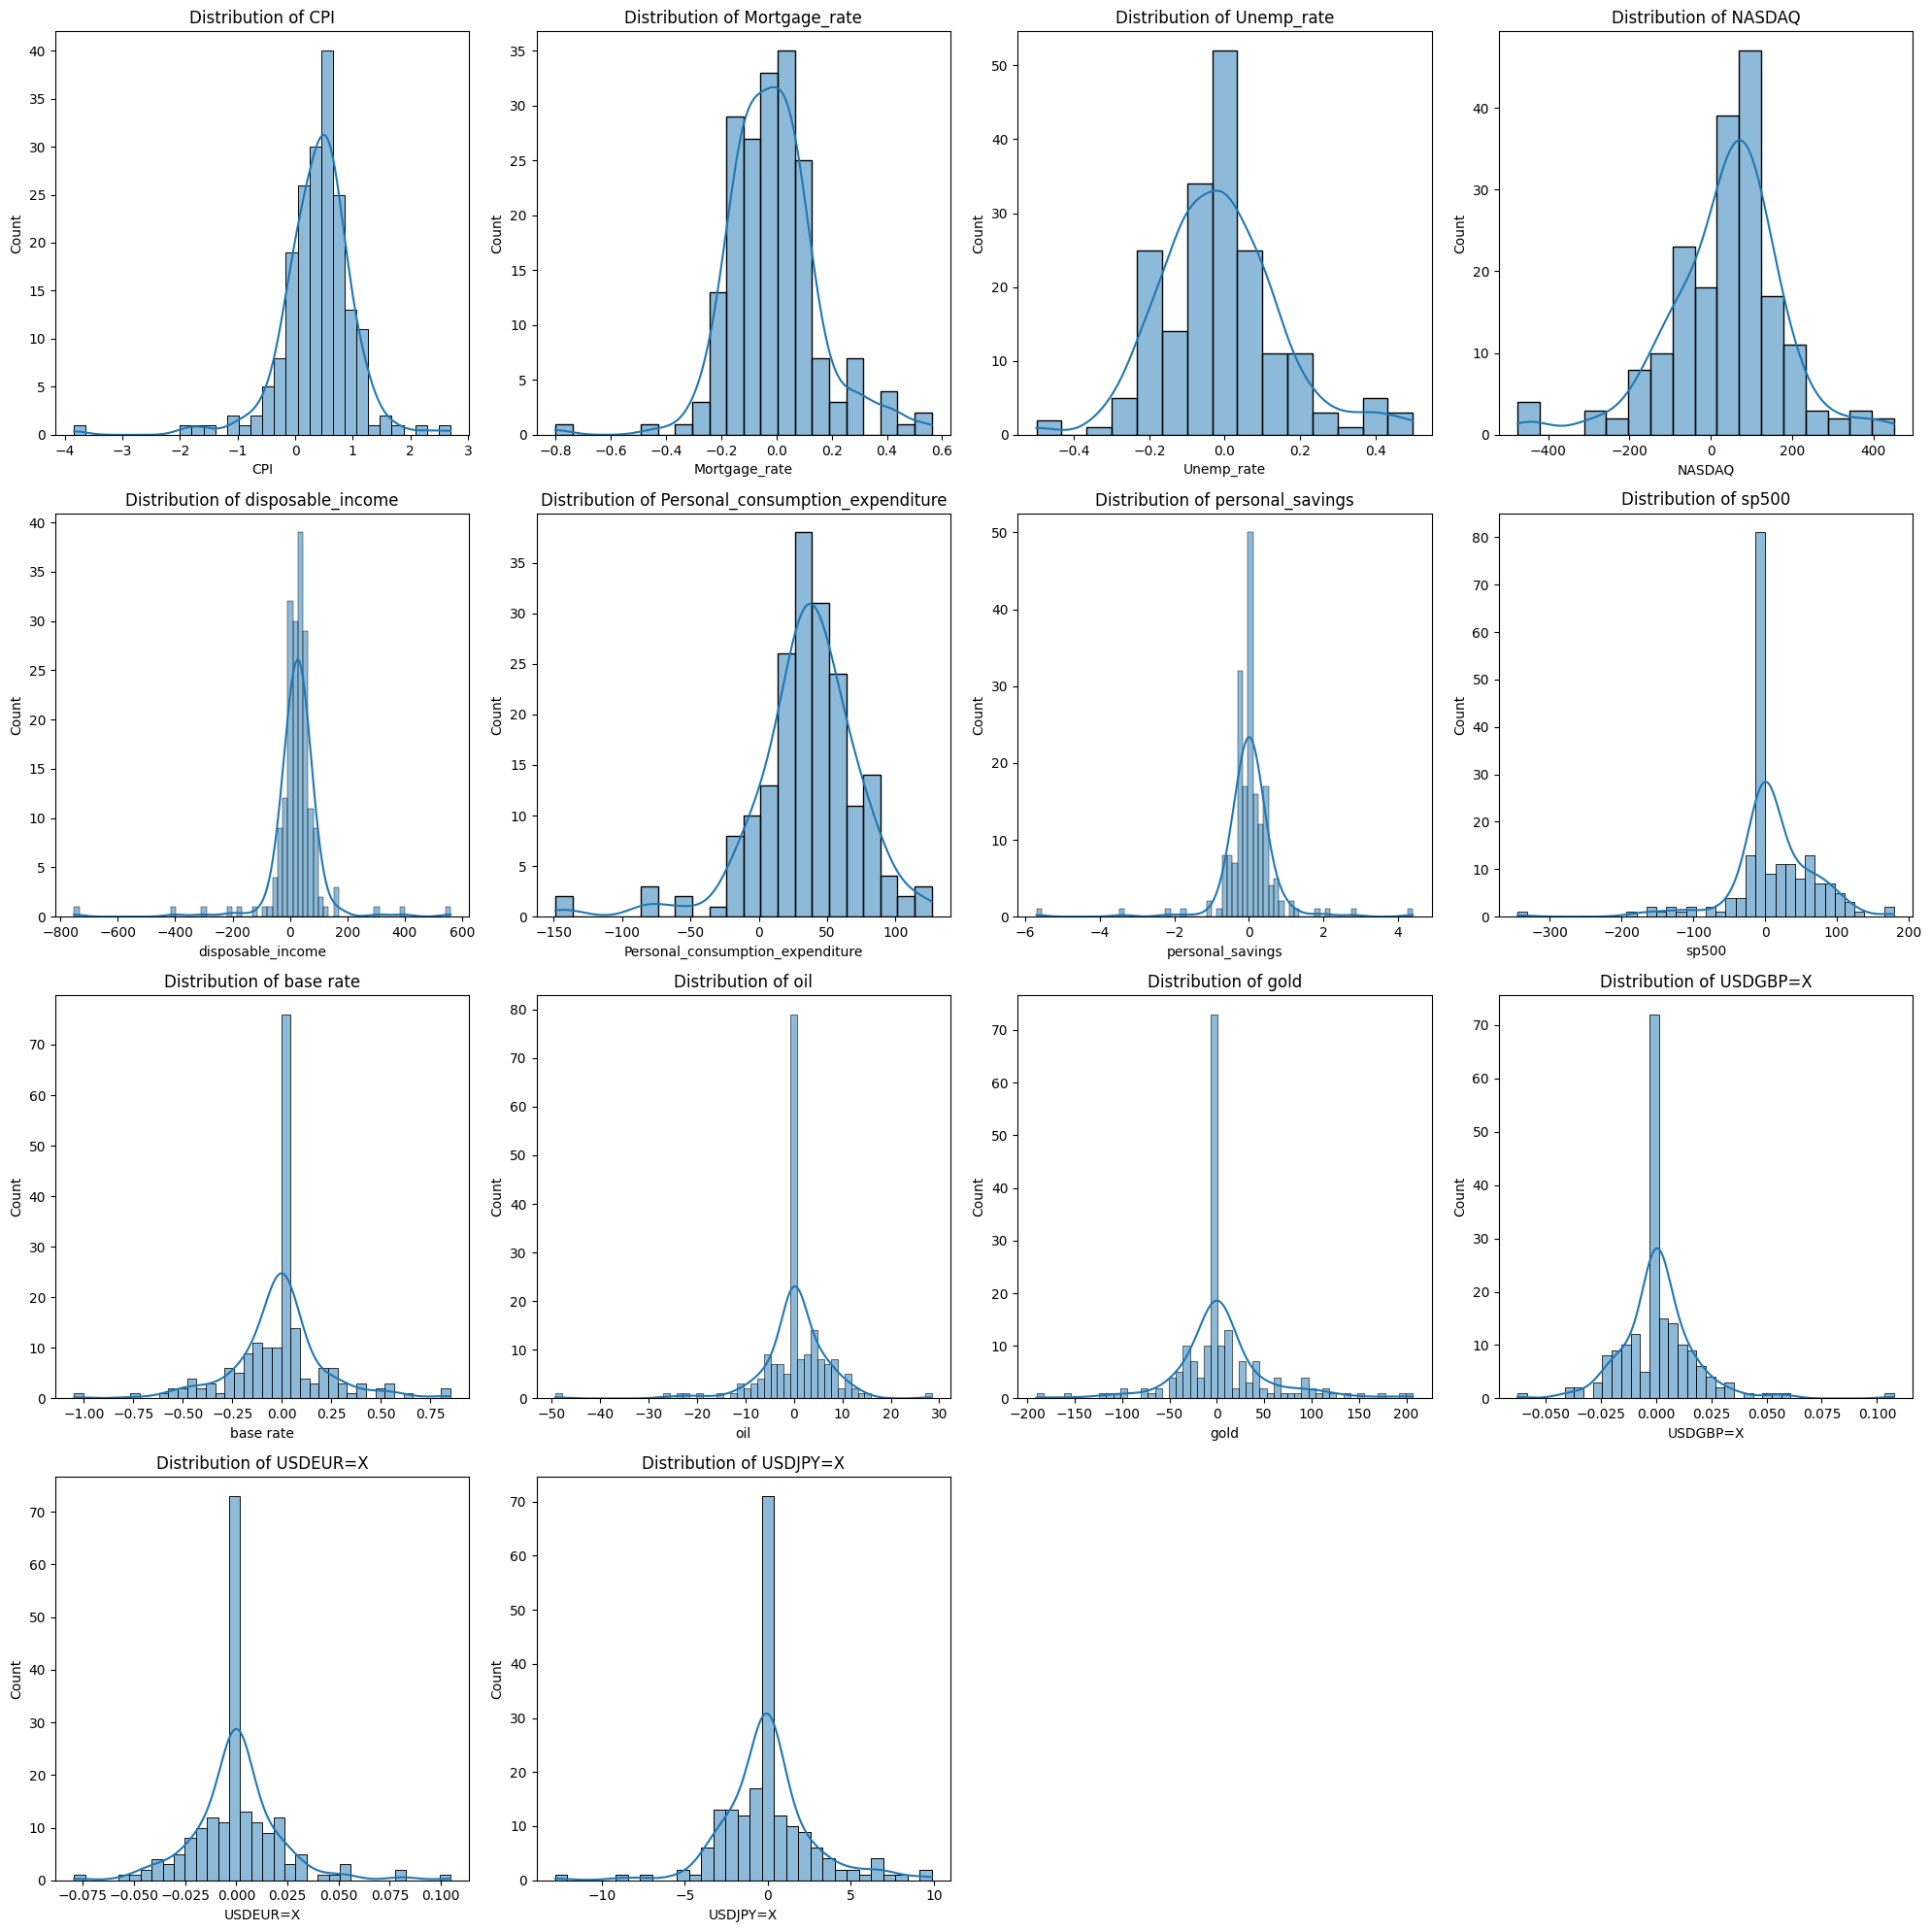

In [ ]:
plt.figure(figsize=(10, 8))  # Keep the correlation matrix at a reasonable size
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
correlation_filename = os.path.join(save_dir, 'correlation_matrix.png')
plt.savefig(correlation_filename, dpi=300)
plt.show()

# Plot the distribution of the target variable if it exists
if 'target' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['target'], kde=True)
    plt.title('Distribution of Target Variable', fontsize=14)
    plt.tight_layout()
    target_filename = os.path.join(save_dir, 'distribution_target.png')
    plt.savefig(target_filename, dpi=300)
    plt.show()

# Number of subplots per row and column for feature distributions
n_cols = 4
columns = [col for col in data.columns if col != 'target']  # Exclude target column
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calculate number of rows

# Set up the grid for distribution plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Loop through each feature and plot its distribution
for i, column in enumerate(columns):
    ax = axes[i]
    sns.histplot(data[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=12)

# Hide unused subplots if there are fewer columns than grid slots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and save the full grid of distributions
plt.tight_layout()
distributions_filename = os.path.join(save_dir, 'distributions_grid.png')
plt.savefig(distributions_filename, dpi=300)
plt.show()

Then we see using the distribution graphs that our data contains outliers and so to keep some of the variability and due to the infrequent nature of outliers with replace these with the upper/lower bound observations.

In [ ]:
def remove_outliers_iqr(df, columns=None, multiplier=1.5):
    """
    Replaces outliers in the specified columns with the lower or upper bound
    as determined by the IQR method.
    """
    if columns is None:
        columns = df.select_dtypes(include=[float, int]).columns

    df_replaced = df.copy()  # Create a copy to avoid modifying the original data
    for col in columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df_replaced[col].quantile(0.05, interpolation='midpoint')
        Q3 = df_replaced[col].quantile(0.95, interpolation='midpoint')
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # Replace values below the lower bound with the lower bound
        df_replaced.loc[df_replaced[col] < lower_bound, col] = lower_bound
        # Replace values above the upper bound with the upper bound
        df_replaced.loc[df_replaced[col] > upper_bound, col] = upper_bound

    return df_replaced

In order to test whether this improves our models we save this to a separate dataset for comparison.

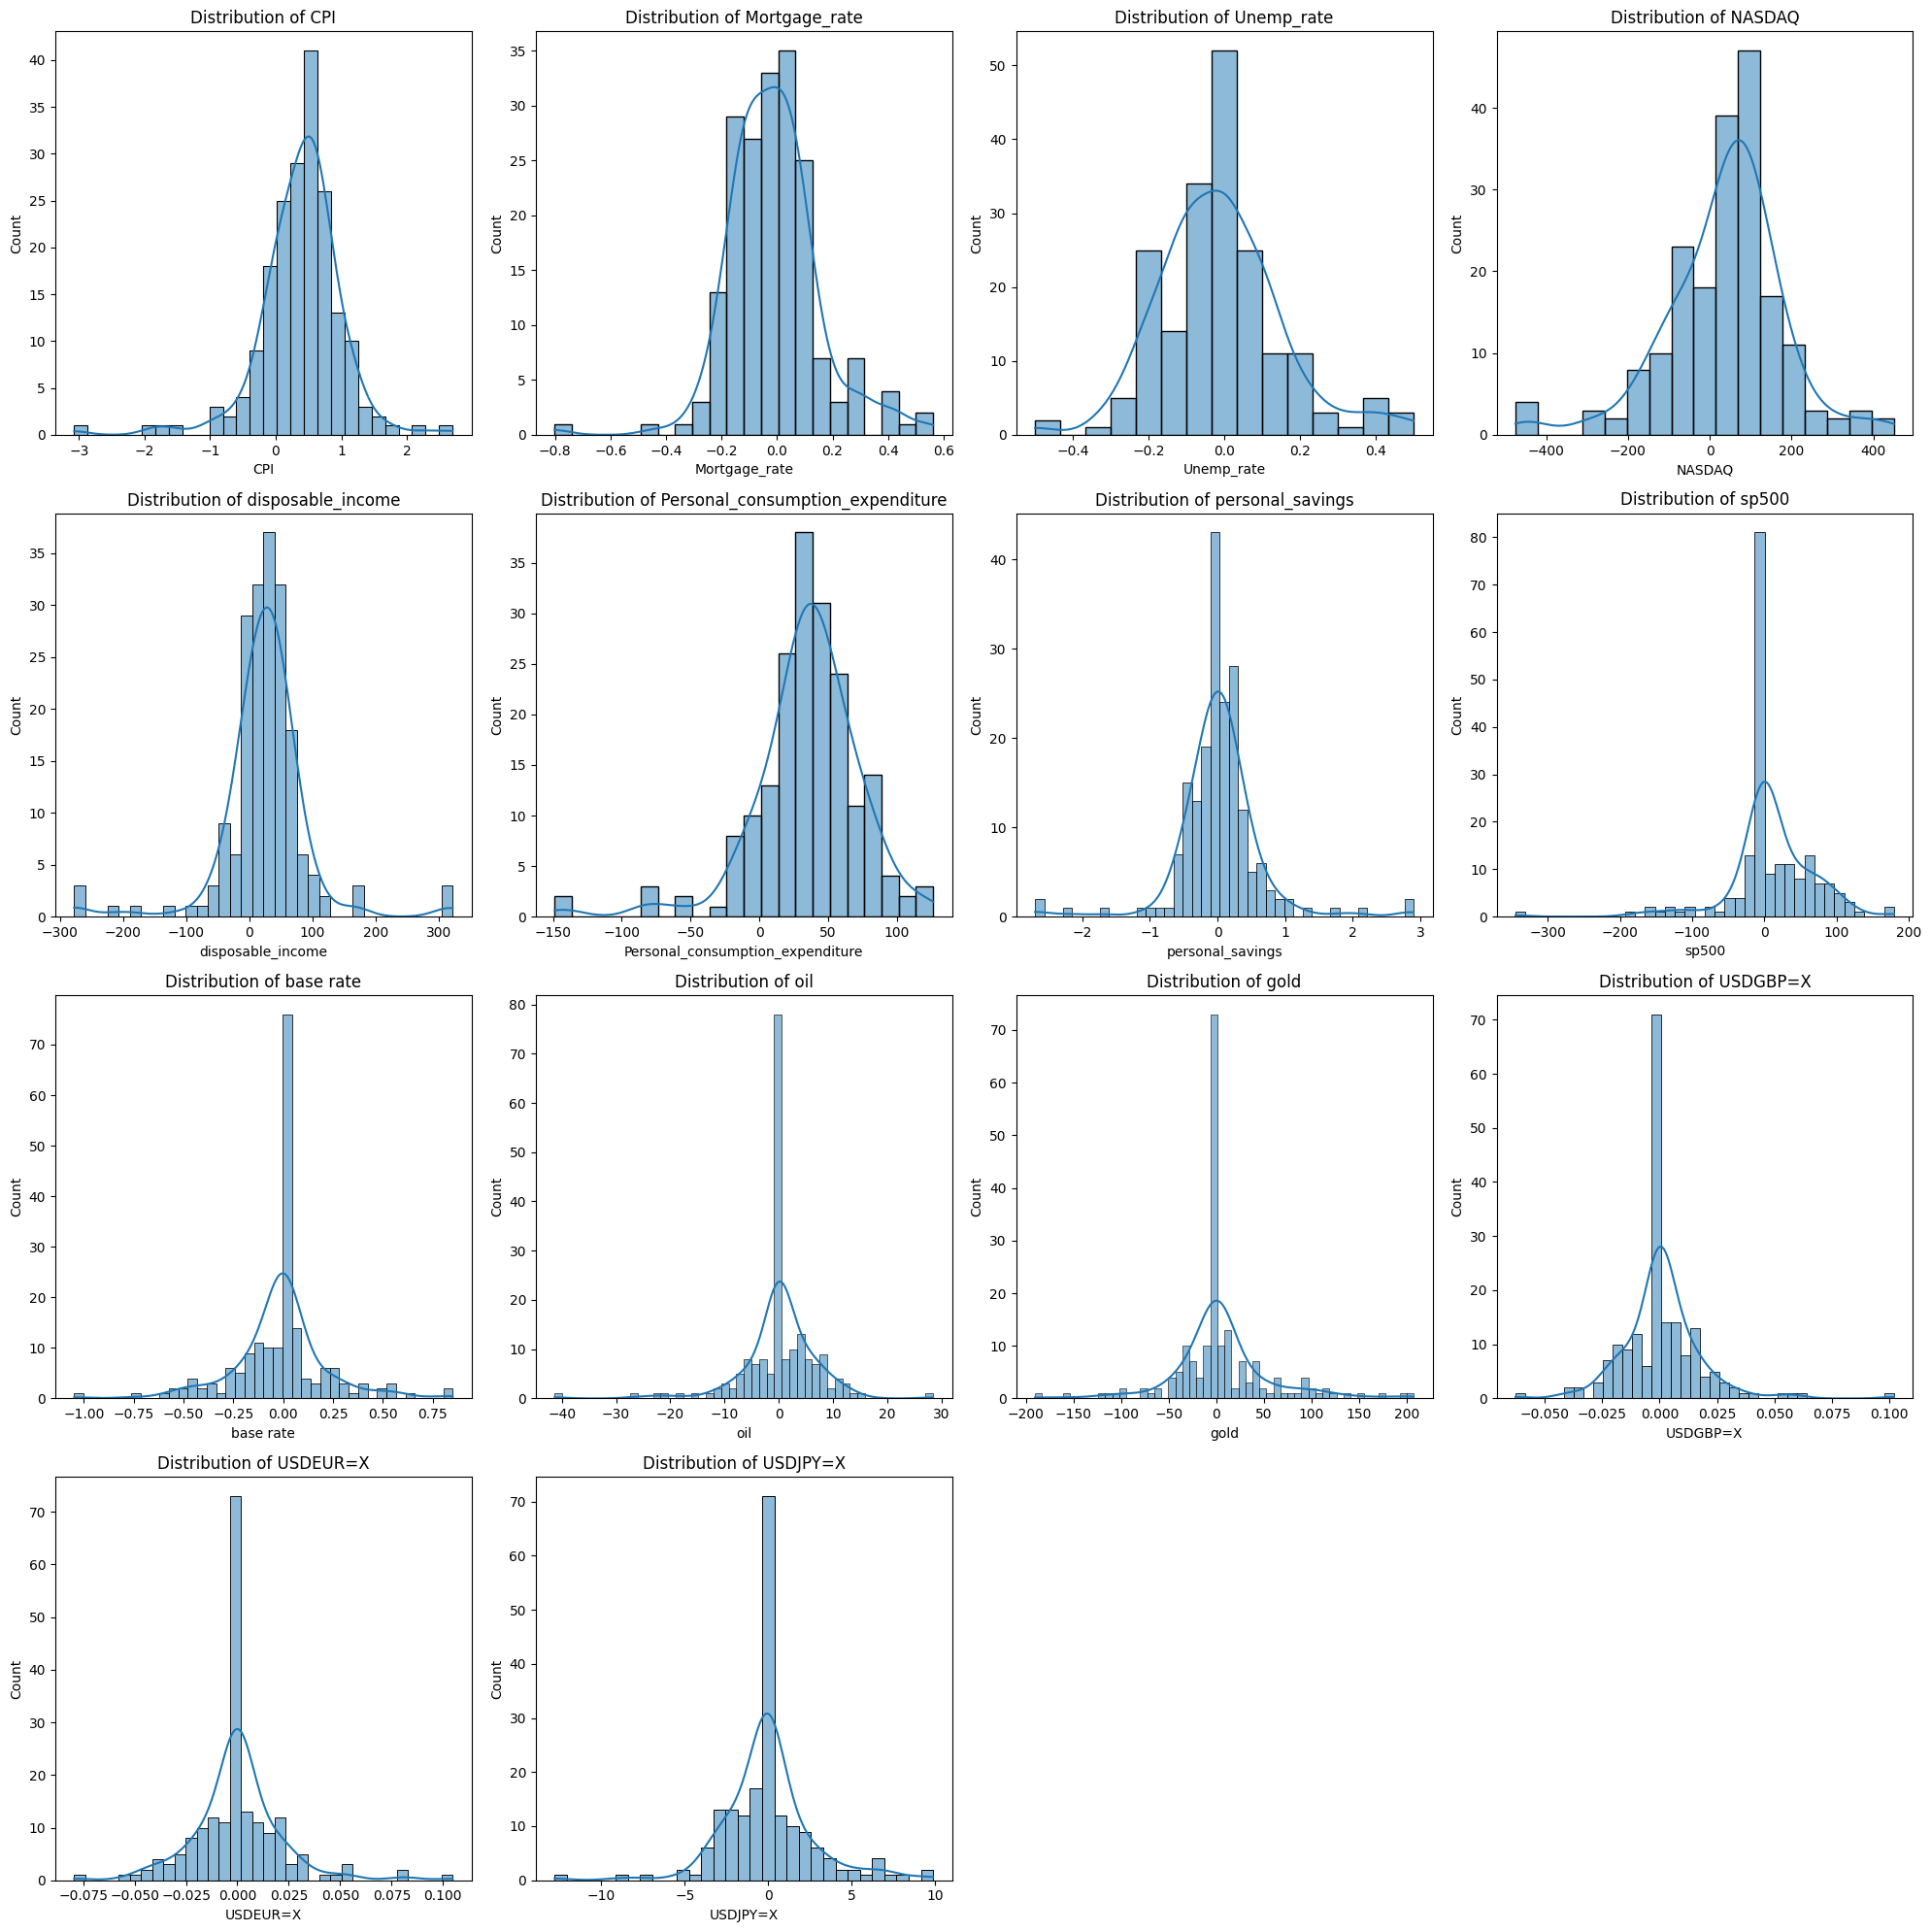

In [ ]:
cleaned_data = remove_outliers_iqr(data, columns=None, multiplier=1.5)

# Plot the distribution of the target variable if it exists
if 'target' in cleaned_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(cleaned_data['target'], kde=True)
    plt.title('Distribution of Target Variable', fontsize=14)
    plt.tight_layout()
    plt.show()

# Number of subplots per row and column for feature distributions
n_cols = 4
columns = [col for col in cleaned_data.columns if col != 'target']  # Exclude target column
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calculate number of rows

# Set up the grid for distribution plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Loop through each feature and plot its distribution
for i, column in enumerate(columns):
    ax = axes[i]
    sns.histplot(cleaned_data[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=12)

# Hide unused subplots if there are fewer columns than grid slots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and save the full grid of distributions
plt.tight_layout()
plt.show()

# Set CPI base to 100 for '2003-12-01'
base_date = data.index[0]
base_value = data.loc[base_date, 'CPI']

# Recalculate CPI to have 100 as base on '2003-12-01'
data['CPI'] = (data['CPI'] / base_value) * 100
cleaned_data['CPI'] = (cleaned_data['CPI'] / base_value) * 100

To Summarise, we backfilled missing stock data values with their previous close to fix the mismatch in our Macro and Stock data. Subsequently, we fix the non-stationarity of our data by taking a first difference of the variables which failed the ADF test and then replace data outliers with the upper/lower bounds. However, we saved an uncleaned version which still contains the outliers to compare which allows for the best training of our models.

## Methodology and Results

We are going to use the following models:

- **OLS** : as a baseline model for comparison of the more complex models against one of the most widely used models.

- **Elastic Net, LASSO and RIDGE** : these models are powerful for stock prediction due to their ability to handle high-dimensional data, where numerous predictors may be collinear. Elastic Net combines LASSO's sparsity with Ridge Regression's penalty, offering a balanced approach for feature selection and regularization.

- **Random Forest** is great at capturing complex, non-linear relationships and interactions among economic indicators, making it ideal for the inherently noisy and dynamic nature of stock markets.

Together, these approaches provide a comprehensive toolkit for modeling, evaluating, and interpreting stock predictions relative to economic factors.

Furthermore we used a data split to train and test the models. If we had more time we would have implemented a time series cross validation method which could have proved more accurate.



### OLS Model:
We do a sample split for all subsequent models and for a base model train OLS. We compare the OLS using a cleaned dataset vs an uncleaned dataset to see whether we should remove outliers.

Training MSE: 1412.5947
Testing MSE: 4194.3690


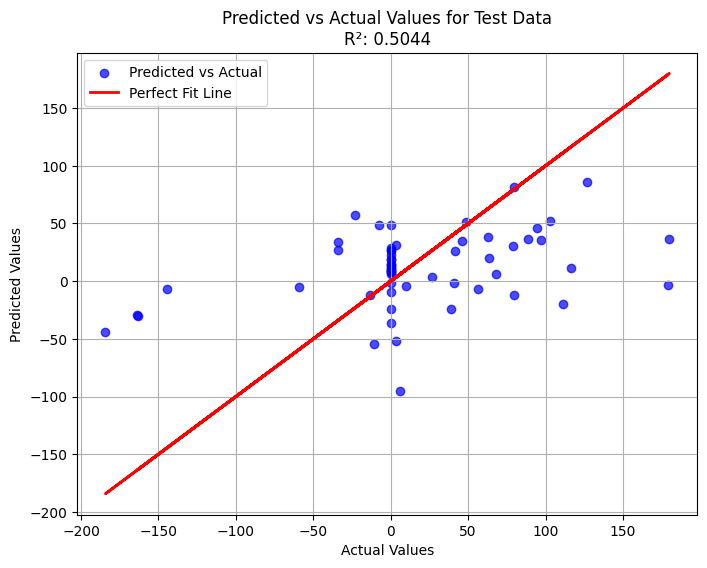

In [ ]:
# Define X (independent variables) and y (dependent variable)
X = data.drop(columns='sp500')  # All columns except 'sp500'
y = data['sp500']               # 'sp500' column as the dependent variable
X = sm.add_constant(X)


# Split the data manually for time-series
split_index = int(0.7 * len(data))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Add constant to X_train and X_test for OLS
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Train the OLS model on the training data
ols_model = sm.OLS(y_train, X_train).fit()

# Make predictions on the training data
train_predictions = ols_model.predict(X_train)

# Calculate MSE for the training data
train_mse = mean_squared_error(y_train, train_predictions)

# Make predictions on the testing data
test_predictions = ols_model.predict(X_test)

# Calculate MSE for the testing data
test_mse = mean_squared_error(y_test, test_predictions)

# Display the results
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

# Calculate R² for the test data
r_squared = ols_model.rsquared

# Plot the predictions vs actual values for the test data with R² on the graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, color='blue', alpha=0.7, label='Predicted vs Actual')
plt.plot(y_test, y_test, color='red', linewidth=2, label='Perfect Fit Line')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual Values for Test Data\nR²: {r_squared:.4f}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sp500   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     9.394
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           3.62e-13
Time:                        17:00:20   Log-Likelihood:                -676.10
No. Observations:                 134   AIC:                             1380.
Df Residuals:                     120   BIC:                             1421.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                4.4990      4.860      0.926      0.356      -5.123      14.121
CPI                                 -0.0600      0.091     -0.661      0.510      -0.240       0.120
Mortgage_rate                       11.3816     24.312      0.468      0.641     -36.755      59.518
Unemp_rate                         -40.5247     20.388     -1.988      0.049     -80.891      -0.158
NASDAQ                               0.0825      0.035      2.334      0.021       0.013       0.153
disposable_income                    0.0155      0.257      0.060      0.952      -0.494       0.525
Personal_consumption_expenditure     0.1131      0.317      0.357      0.722      -0.514       0.740
personal_savings                     7.1276     33.298      0.214      0.831     -58.800      73.055
base rate                           31.2270     19.876      1.571      0.119      -8.127      70.581
oil                                  0.8482      0.642      1.322      0.189      -0.422       2.118
gold                                 0.0210      0.071      0.297      0.767      -0.119       0.161
USDGBP=X                          -558.2514    311.680     -1.791      0.076   -1175.355      58.852
USDEUR=X                          -582.6914    243.770     -2.390      0.018   -1065.339    -100.044
USDJPY=X                             4.3840      1.456      3.011      0.003       1.501       7.267
==============================================================================
Omnibus:                        5.246   Durbin-Watson:                   2.381
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                5.295
Skew:                           0.308   Prob(JB):                       0.0708
Kurtosis:                       3.754   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

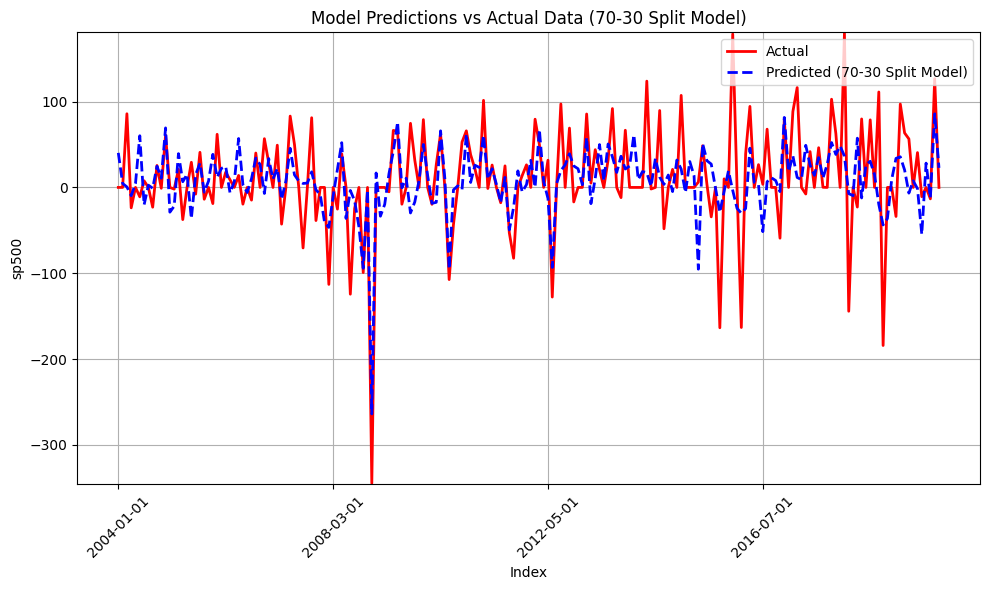

In [ ]:
# Predict for the entire dataset using the model trained on the 70% training split
split_model_predictions = ols_model.predict(X)

# Plot Model Predictions vs Actual Data using the split-trained model
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["sp500"], color='red', linewidth=2, label='Actual')  # Actual data
plt.plot(data.index, split_model_predictions, color='blue', linewidth=2, linestyle='--', label='Predicted (70-30 Split Model)')  # Predictions
plt.xlabel('Index')
plt.ylabel('sp500')
plt.ylim(data['sp500'].min() - 1, data['sp500'].max() + 1)  # Set appropriate y-axis limits
plt.title('Model Predictions vs Actual Data (70-30 Split Model)')
plt.legend(loc='upper right')
plt.xticks(ticks=data.index[::50], rotation=45)  # Show fewer x-axis labels for clarity
plt.grid()
plt.tight_layout()
plt.show()

Analysis on cleaned data:

Training MSE: 1419.0237
Testing MSE: 4183.9217


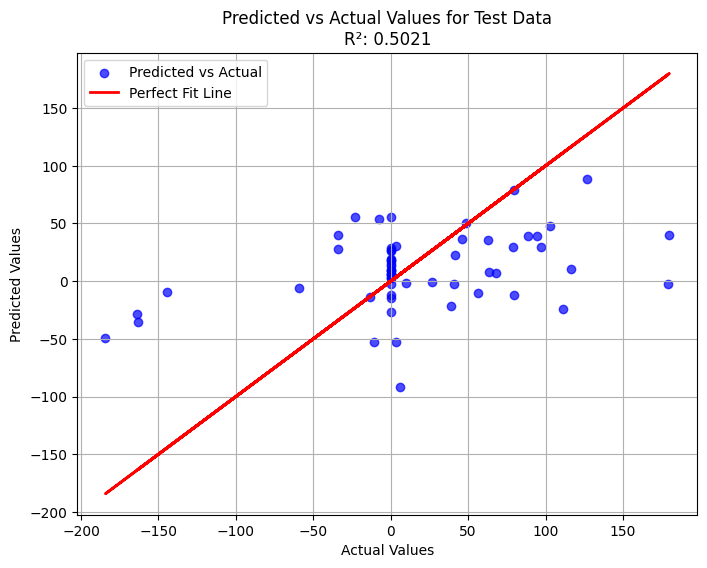

In [ ]:
# Define X (independent variables) and y (dependent variable)
X_clean = cleaned_data.drop(columns='sp500')  # All columns except 'sp500'
y_clean = cleaned_data['sp500']               # 'sp500' column as the dependent variable
X_clean = sm.add_constant(X_clean)


# Split the data manually for time-series
split_index = int(0.7 * len(cleaned_data))
X_train_clean, X_test_clean = X_clean.iloc[:split_index], X_clean.iloc[split_index:]
y_train_clean, y_test_clean = y_clean.iloc[:split_index], y_clean.iloc[split_index:]

# Train the OLS model on the training data
ols_model_clean = sm.OLS(y_train_clean, X_train_clean).fit()

# Make predictions on the training data
train_predictions_clean = ols_model_clean.predict(X_train_clean)

# Calculate MSE for the training data
train_mse_clean = mean_squared_error(y_train_clean, train_predictions_clean)

# Make predictions on the testing data
test_predictions_clean = ols_model_clean.predict(X_test_clean)

# Calculate MSE for the testing data
test_mse_clean = mean_squared_error(y_test_clean, test_predictions_clean)

# Display the results
print(f"Training MSE: {train_mse_clean:.4f}")
print(f"Testing MSE: {test_mse_clean:.4f}")

# Calculate R² for the test data
r_squared_clean = ols_model_clean.rsquared

# Plot the predictions vs actual values for the test data with R² on the graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, test_predictions_clean, color='blue', alpha=0.7, label='Predicted vs Actual')
plt.plot(y_test_clean, y_test_clean, color='red', linewidth=2, label='Perfect Fit Line')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual Values for Test Data\nR²: {r_squared_clean:.4f}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ols_model_clean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sp500   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     9.310
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           4.64e-13
Time:                        17:00:20   Log-Likelihood:                -676.41
No. Observations:                 134   AIC:                             1381.
Df Residuals:                     120   BIC:                             1421.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                3.3889      4.898      0.692      0.490      -6.308      13.086
CPI                                  0.0027      0.099      0.027      0.979      -0.193       0.198
Mortgage_rate                       12.9394     24.435      0.530      0.597     -35.440      61.319
Unemp_rate                         -39.6807     20.452     -1.940      0.055     -80.174       0.813
NASDAQ                               0.0826      0.035      2.327      0.022       0.012       0.153
disposable_income                    0.1999      0.268      0.745      0.458      -0.332       0.731
Personal_consumption_expenditure    -0.0658      0.303     -0.217      0.829      -0.666       0.535
personal_savings                   -10.6740     30.890     -0.346      0.730     -71.834      50.486
base rate                           33.4921     20.094      1.667      0.098      -6.294      73.278
oil                                  0.7247      0.666      1.089      0.278      -0.593       2.043
gold                                 0.0241      0.071      0.340      0.734      -0.116       0.164
USDGBP=X                          -587.0052    314.681     -1.865      0.065   -1210.051      36.040
USDEUR=X                          -564.6737    244.840     -2.306      0.023   -1049.441     -79.907
USDJPY=X                             4.1147      1.475      2.790      0.006       1.195       7.035
==============================================================================
Omnibus:                        4.709   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.342
Skew:                           0.327   Prob(JB):                        0.114
Kurtosis:                       3.591   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

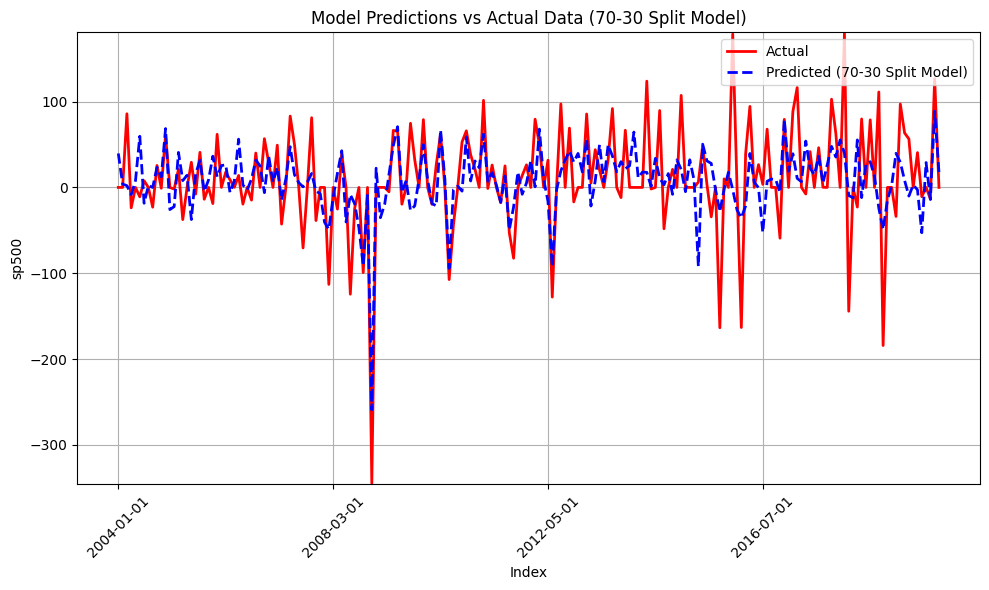

In [ ]:
# Predict for the entire dataset using the model trained on the 70% training split
split_model_predictions_clean = ols_model_clean.predict(X_clean)

# Plot Model Predictions vs Actual Data using the split-trained model
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data.index, cleaned_data["sp500"], color='red', linewidth=2, label='Actual')  # Actual data
plt.plot(cleaned_data.index, split_model_predictions_clean, color='blue', linewidth=2, linestyle='--', label='Predicted (70-30 Split Model)')  # Predictions
plt.xlabel('Index')
plt.ylabel('sp500')
plt.ylim(cleaned_data['sp500'].min() - 1, cleaned_data['sp500'].max() + 1)  # Set appropriate y-axis limits
plt.title('Model Predictions vs Actual Data (70-30 Split Model)')
plt.legend(loc='upper right')
plt.xticks(ticks=cleaned_data.index[::50], rotation=45)  # Show fewer x-axis labels for clarity
plt.grid()
plt.tight_layout()
plt.show()

### Elastic Net, LASSO and RIDGE

The plots show how the coefficients of the Elastic Net, LASSO, and RIDGE Regression models for various features relate to the regularisation strength (𝜆). The regularised linear regression models Elastic Net, LASSO, and RIDGE incorporate a penalty term (𝜆) to reduce coefficient values, hence mitigating multicollinearity and avoiding overfitting.


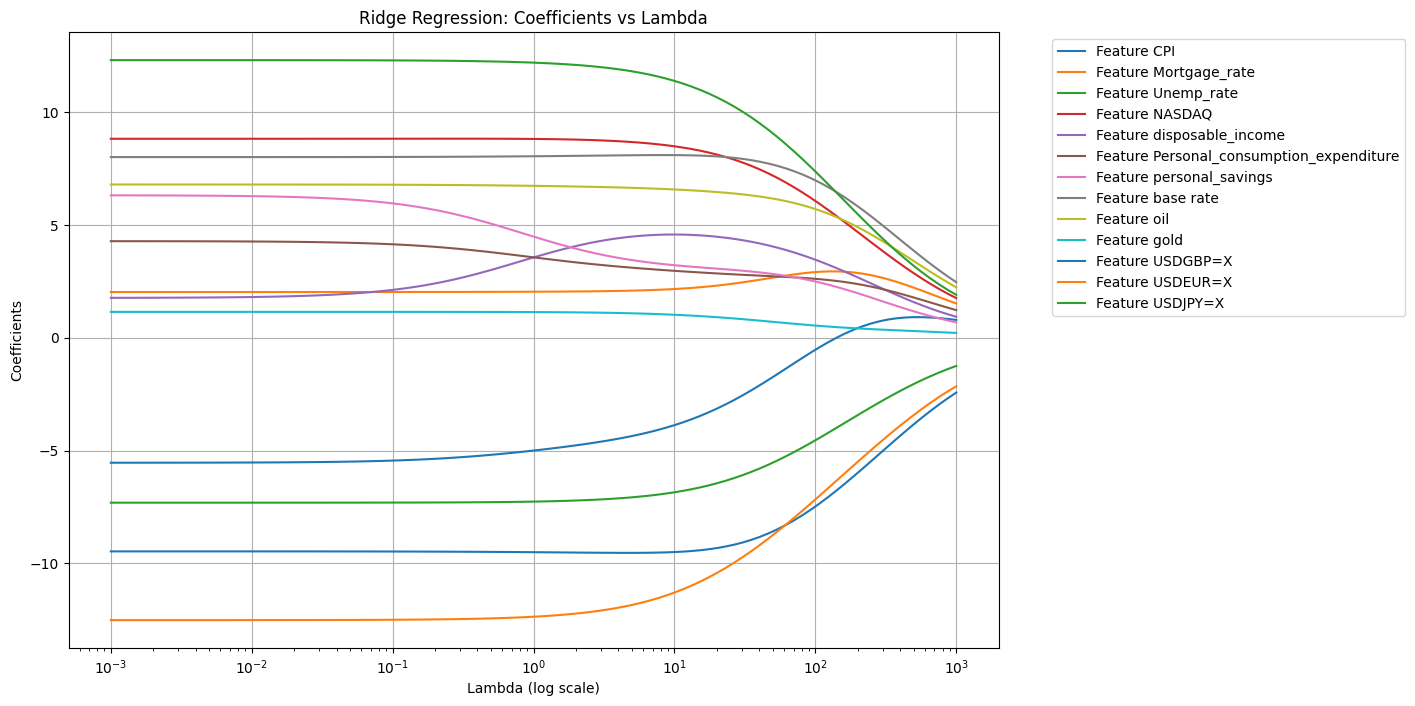

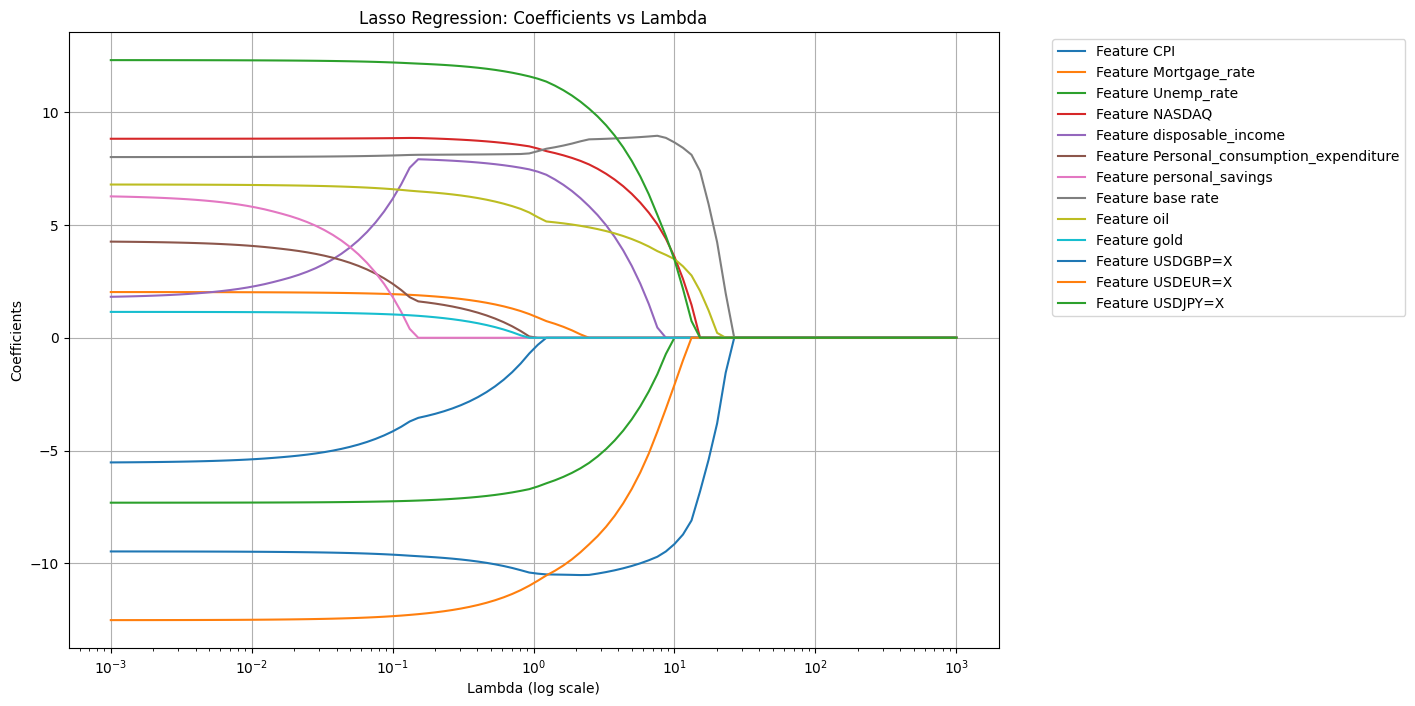

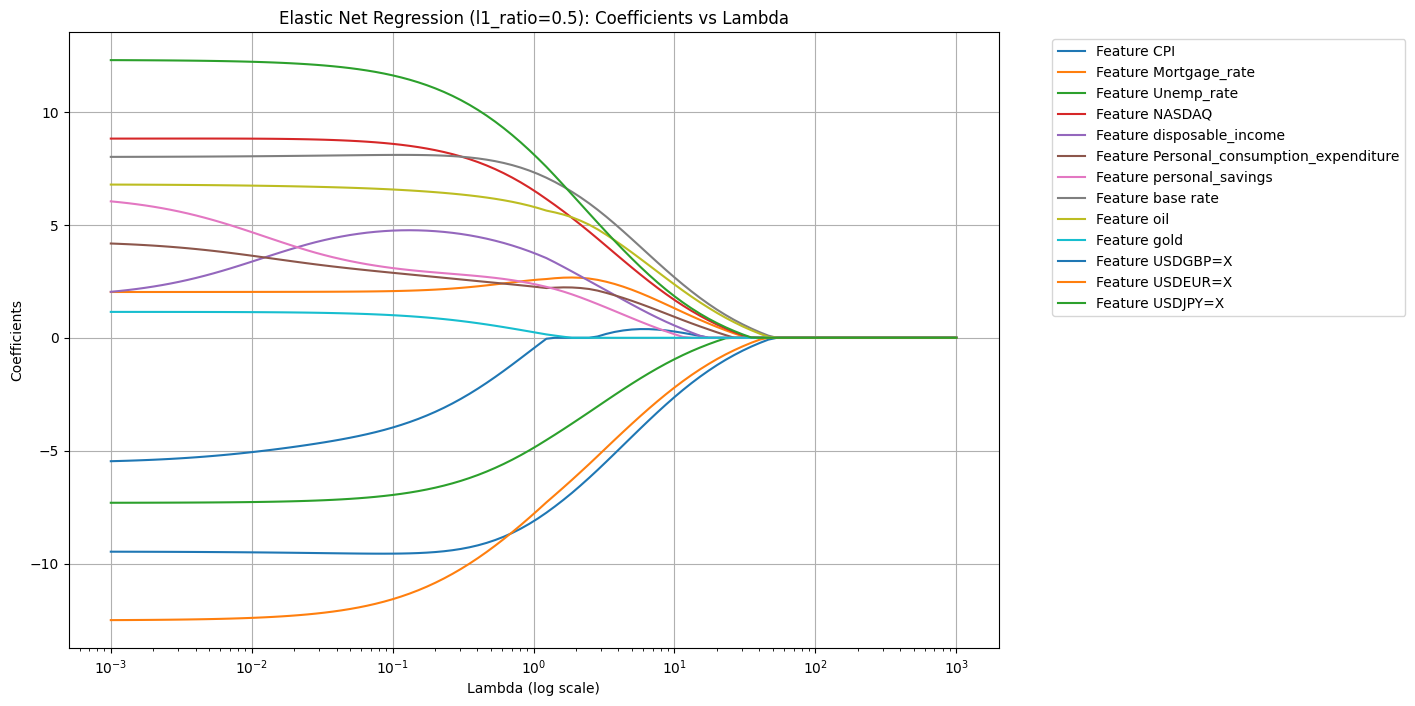

In [ ]:
# Define X (independent variables) and y (dependent variable)
X = data.drop(columns='sp500')  # All columns except 'sp500'
y = data['sp500']               # 'sp500' column as the dependent variable

# Split data into train and test sets
split_index = int(0.7 * len(data))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range of lambda values (alphas)
alphas_forex = np.logspace(-3, 3, 100)

# Visualize coefficient evolution for Ridge, Lasso, and Elastic Net
ridge_coefs = []
lasso_coefs = []
elastic_coefs = []
l1_ratio = 0.5  # Elastic Net mix parameter

# Ridge Regression Coefficients
for alpha in alphas_forex:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.array(ridge_coefs)

plt.figure(figsize=(12, 8))
for i in range(ridge_coefs.shape[1]):
    plt.plot(alphas_forex, ridge_coefs[:, i], label=f'Feature {X.columns[i]}')
plt.xscale('log')
plt.title('Ridge Regression: Coefficients vs Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficients')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid()
plt.show()

# Lasso Regression Coefficients
for alpha in alphas_forex:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)
lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(12, 8))
for i in range(lasso_coefs.shape[1]):
    plt.plot(alphas_forex, lasso_coefs[:, i], label=f'Feature {X.columns[i]}')
plt.xscale('log')
plt.title('Lasso Regression: Coefficients vs Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficients')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid()
plt.show()

# Elastic Net Coefficients
for alpha in alphas_forex:
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    elastic_net.fit(X_train_scaled, y_train)
    elastic_coefs.append(elastic_net.coef_)
elastic_coefs = np.array(elastic_coefs)

plt.figure(figsize=(12, 8))
for i in range(elastic_coefs.shape[1]):
    plt.plot(alphas_forex, elastic_coefs[:, i], label=f'Feature {X.columns[i]}')
plt.xscale('log')
plt.title(f'Elastic Net Regression (l1_ratio={l1_ratio}): Coefficients vs Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficients')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid()
plt.show()


Therefore RidgeCV, LassoCV, and ElasticNetCV are used to automatically select the "best lambda" (and, for Elastic Net, the best
L1
_ ratio) using cross-validation.
The final "best lambda" values are those that minimize the cross-validated mean squared error (MSE) during model fitting.
These "best lambda" values from cross-validation are used for predictions, train/test MSE calculations, and identifying the best-performing model.

In [ ]:
# Re-run Ridge, Lasso, and Elastic Net regressions with cross-validated lambdas

# Ridge Regression with CV
ridge_cv = RidgeCV(alphas=alphas_forex, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
ridge_best_lambda = ridge_cv.alpha_
ridge_train_pred = ridge_cv.predict(X_train_scaled)
ridge_test_pred = ridge_cv.predict(X_test_scaled)
ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)

# Lasso Regression with CV
lasso_cv = LassoCV(alphas=alphas_forex, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
lasso_best_lambda = lasso_cv.alpha_
lasso_train_pred = lasso_cv.predict(X_train_scaled)
lasso_test_pred = lasso_cv.predict(X_test_scaled)
lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)

# Elastic Net with CV
elastic_net_cv = ElasticNetCV(alphas=alphas_forex, l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0], cv=5, max_iter=10000)
elastic_net_cv.fit(X_train_scaled, y_train)
elastic_best_lambda = elastic_net_cv.alpha_
elastic_best_l1_ratio = elastic_net_cv.l1_ratio_
elastic_train_pred = elastic_net_cv.predict(X_train_scaled)
elastic_test_pred = elastic_net_cv.predict(X_test_scaled)
elastic_train_mse = mean_squared_error(y_train, elastic_train_pred)
elastic_test_mse = mean_squared_error(y_test, elastic_test_pred)
elastic_test_r2 = r2_score(y_test, elastic_test_pred)


# Compile results
best_lambda_results = {
    "Ridge": {
        "Best Lambda": ridge_best_lambda,
        "Train MSE": ridge_train_mse,
        "Test MSE": ridge_test_mse,
    },
    "Lasso": {
        "Best Lambda": lasso_best_lambda,
        "Train MSE": lasso_train_mse,
        "Test MSE": lasso_test_mse,
    },
    "Elastic Net": {
        "Best Lambda": elastic_best_lambda,
        "Best L1 Ratio": elastic_best_l1_ratio,
        "Train MSE": elastic_train_mse,
        "Test MSE": elastic_test_mse,
    },
}

# Determine the best model by Train MSE and Test MSE
best_model_by_train_mse = min(best_lambda_results, key=lambda x: best_lambda_results[x]["Train MSE"])
best_model_by_test_mse = min(best_lambda_results, key=lambda x: best_lambda_results[x]["Test MSE"])

best_model_results = {
    "Best Model by Train MSE": {
        "Model": best_model_by_train_mse,
        "Details": best_lambda_results[best_model_by_train_mse],
    },
    "Best Model by Test MSE": {
        "Model": best_model_by_test_mse,
        "Details": best_lambda_results[best_model_by_test_mse],
    },
}

# Output all results
best_lambda_results, best_model_results


({'Ridge': {'Best Lambda': 187.3817422860383,
   'Train MSE': 1631.9386449822082,
   'Test MSE': 4122.468385863677},
  'Lasso': {'Best Lambda': 0.23101297000831605,
   'Train MSE': 1413.7893191368644,
   'Test MSE': 4182.144186645285},
  'Elastic Net': {'Best Lambda': 0.26560877829466867,
   'Best L1 Ratio': 0.1,
   'Train MSE': 1433.4259693414924,
   'Test MSE': 4095.3593107315937}},
 {'Best Model by Train MSE': {'Model': 'Lasso',
   'Details': {'Best Lambda': 0.23101297000831605,
    'Train MSE': 1413.7893191368644,
    'Test MSE': 4182.144186645285}},
  'Best Model by Test MSE': {'Model': 'Elastic Net',
   'Details': {'Best Lambda': 0.26560877829466867,
    'Best L1 Ratio': 0.1,
    'Train MSE': 1433.4259693414924,
    'Test MSE': 4095.3593107315937}}})

The Lasso model matches the training set more closely than the other models, as evidenced by its superior performance on the training data.
But compared to Ridge or Elastic Net, its larger Test MSE (41882.14) raises the possibility that it overfits a little or does not generalise as well to unknown data.

Better generalisation to unknown data is indicated by the Elastic Net model's lowest Test MSE.
This implies that by combining the Lasso and Ridge penalties, Elastic Net achieves a decent balance between underfitting and overfitting.
Elastic Net's results are near to Ridge since it mostly relies on the Ridge penalty (𝐿 2), given its best 𝐿 1 Ratio of 0.1.


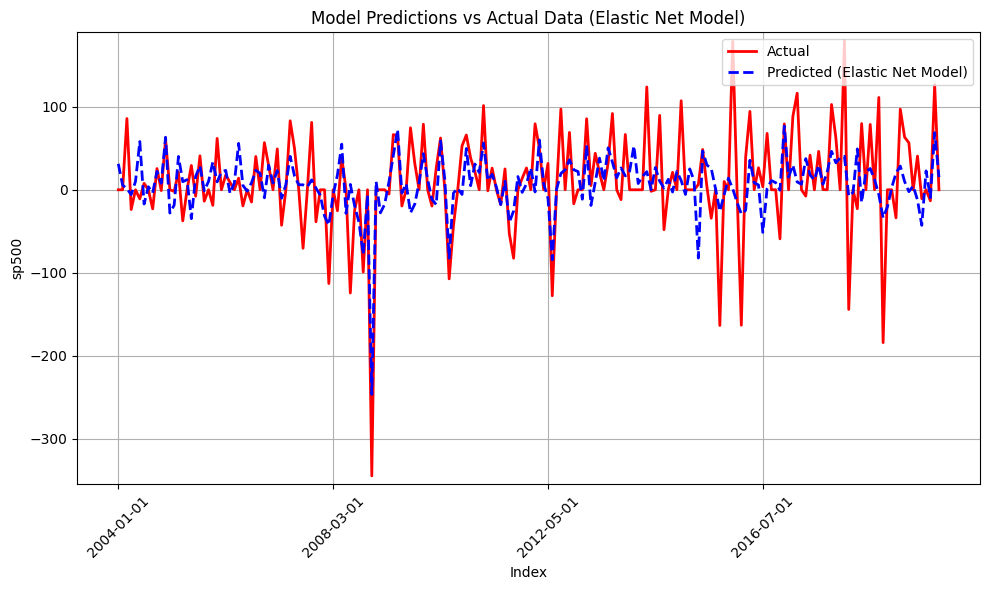

In [ ]:
# Predict for the entire dataset using the full dataset (not split-trained model)
X_scaled = scaler.fit_transform(X)
full_model_predictions_elasticnet = elastic_net_cv.predict(X_scaled)

# Plot Model Predictions vs Actual Data using the full-trained model
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["sp500"], color='red', linewidth=2, label='Actual')  # Actual data
plt.plot(
    data.index[:len(full_model_predictions_elasticnet)],
    full_model_predictions_elasticnet,
    color='blue', linewidth=2, linestyle='--', label='Predicted (Elastic Net Model)'
)  # Predictions
plt.xlabel('Index')
plt.ylabel('sp500')
plt.ylim(data['sp500'].min() - 10, data['sp500'].max() + 10)  # Set appropriate y-axis limits
plt.title('Model Predictions vs Actual Data (Elastic Net Model)')
plt.legend(loc='upper right')
plt.xticks(ticks=data.index[::50], rotation=45)  # Show fewer x-axis labels for clarity
plt.grid()
plt.tight_layout()
plt.show()

## Random Forest Model:
The Random Forest regression model used to predict the S&P 500 index combines robust ensemble learning, hyperparameter tuning, and performance evaluation techniques to achieve strong predictive accuracy and interpretability. The data was split into training (70%) and test (30%) sets, with hyperparameters (e.g., number of trees, maximum depth) optimized using GridSearchCV with 5-fold cross-validation. The best model was evaluated using metrics like
𝑅-squared
 , Mean Absolute Error (MAE), and Mean Squared Error (MSE), ensuring comprehensive insights into its predictive performance. Scatter plots of predicted vs. actual values and time-series overlays highlighted the model’s ability to capture trends and make accurate predictions. Feature importance analysis, derived from the Random Forest model, identified the most influential predictors of the S&P 500 index, offering valuable interpretive insights. The combination of robust performance, generalizability, and interpretability makes this Random Forest model a powerful tool for financial forecasting and decision-making.

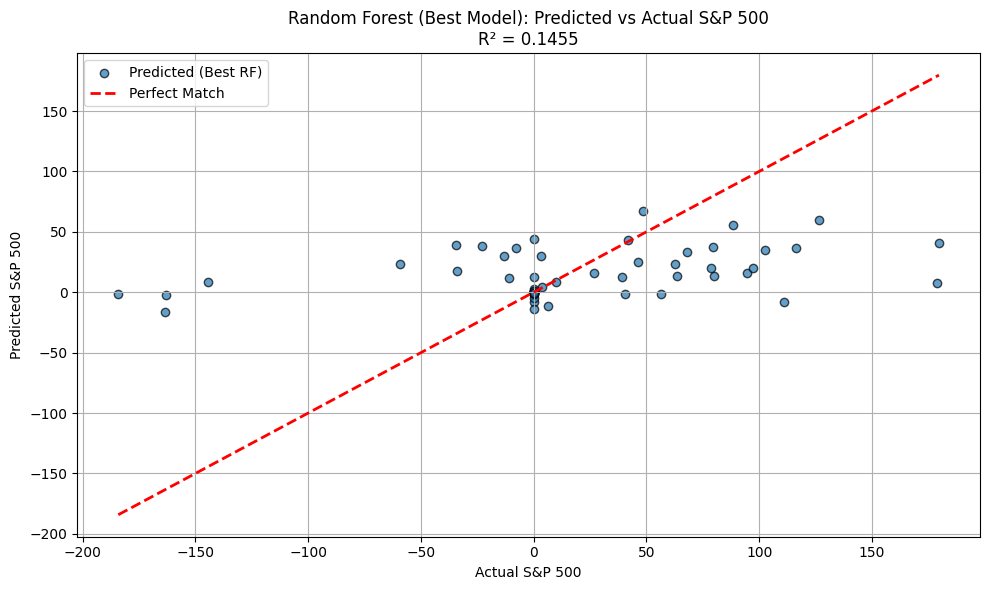

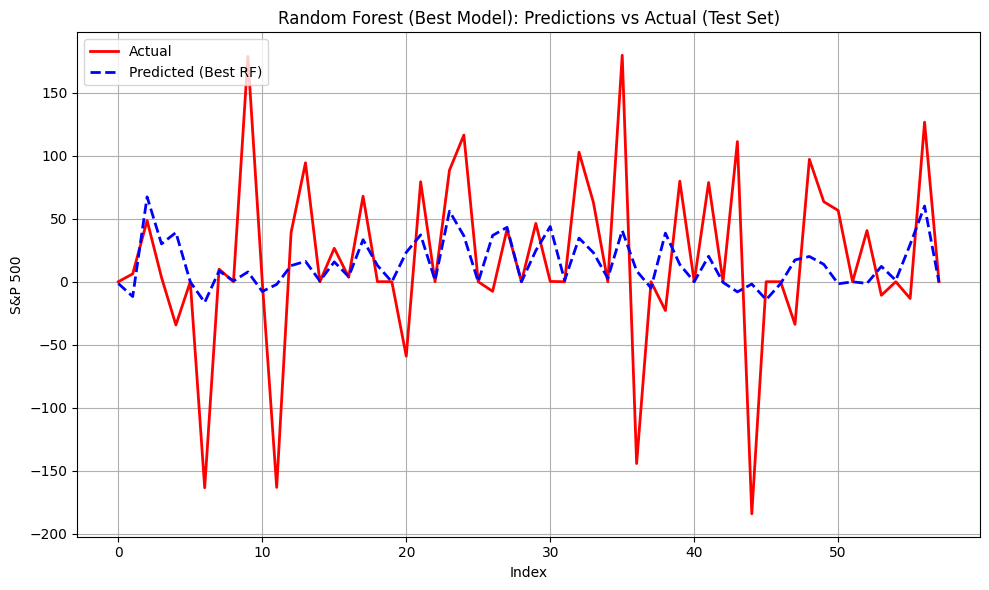

<ipython-input-37-31246a9ea688>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


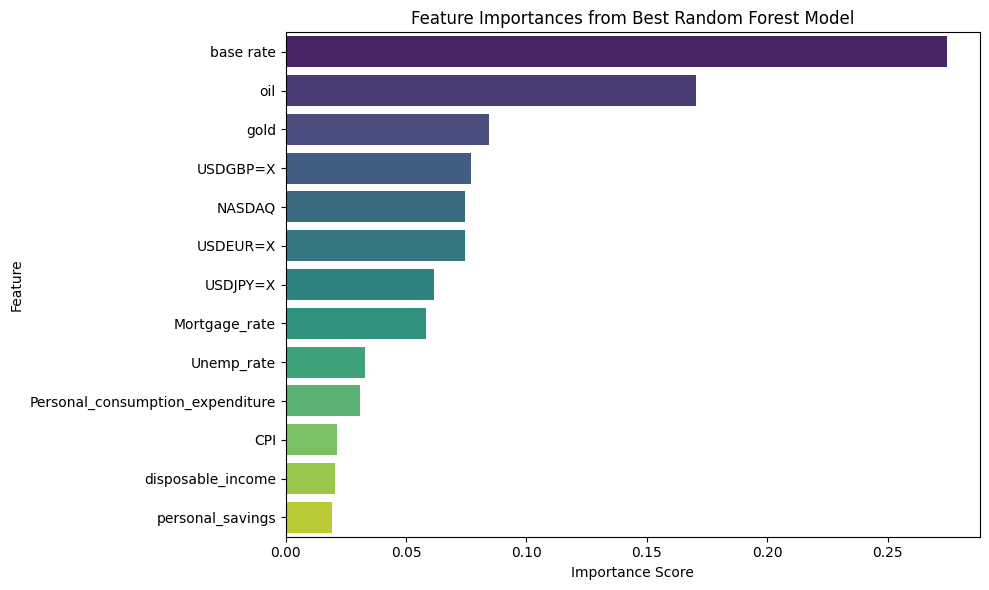

In [ ]:
# Define the features (X) and target (y)
X = data.drop(columns=['sp500'])  # Features
y = data['sp500']                 # Target

# Split data into train and test sets
split_index = int(0.7 * len(data))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Initialize Random Forest and apply hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the test set using the best model
y_train_rf = best_rf_model.predict(X_train)
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse_train = mean_squared_error(y_train, y_train_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)

# Compute R² score
r2 = r2_score(y_test, y_pred_rf)

# Scatter plot of predicted vs actual values for the best Random Forest model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Predicted (Best RF)', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Match')
plt.title(f'Random Forest (Best Model): Predicted vs Actual S&P 500\nR² = {r2:.4f}')
plt.xlabel('Actual S&P 500')
plt.ylabel('Predicted S&P 500')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualize Predictions vs Actual (using best model predictions)
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual', color='red', linewidth=2)
plt.plot(y_pred_rf, label='Predicted (Best RF)', color='blue', linestyle='--', linewidth=2)
plt.title('Random Forest (Best Model): Predictions vs Actual (Test Set)')
plt.xlabel('Index')
plt.ylabel('S&P 500')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Feature Importance Visualization (from the best Random Forest model)
importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[sorted_indices],
    y=[X.columns[i] for i in sorted_indices],
    palette="viridis",
    orient='h'
)
plt.title("Feature Importances from Best Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# Create a more readable output format for Random Forest results
print("Random Forest Model Evaluation:")
print("---------------------------------")
print(f"Best Parameters: {best_params}")
print(f"R² (Test Set): {rf_r2:.4f}")
print(f"Mean Absolute Error (Test Set): {rf_mae:.4f}")
print(f"Mean Squared Error (Train Set): {rf_mse_train:.4f}")
print(f"Mean Squared Error (Test Set): {rf_mse:.4f}")

Random Forest Model Evaluation:
---------------------------------
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² (Test Set): 0.1455
Mean Absolute Error (Test Set): 42.5037
Mean Squared Error (Train Set): 281.4340
Mean Squared Error (Test Set): 4200.1885


The best parameters for the Random Forest model were determined by hyperparameter tuning: an ensemble of 100 decision trees (n_estimators), a maximum tree depth of 10 (max_depth), a minimum of 1 sample per leaf node (min_samples_leaf), and a minimum of 2 samples needed for splitting (min_samples_split). A reasonable tree depth aids in generalisation while preserving predictive ability, and these values show a compromise between model complexity and overfitting. The model's 𝑅-squared on the test set was 0.1455, indicating that it explained only 14.55% of the variance in the S&P 500 index.

A notable discrepancy between the test Mean Squared Error (MSE) of 4200.1885 and the training MSE of 281.4340, however, indicates overfitting, in which the model fits the training data far better than the unseen data.

This performance demonstrates the limitations of the current model's generalisation capabilities, which may be brought on by inadequate feature engineering or less-than-ideal parameter values. The need for better input features, like adding lagged variables, eliminating unnecessary predictors, or capturing nonlinear interactions, is indicated by the low 𝑅-squared and high test MSE. Performance may also be enhanced by extending hyperparameter tuning to include greater values for parameters like as n_estimators, max_depth, or min_samples_split. Additionally, investigating different models that are better able to handle complicated patterns, such as LightGBM, XGBoost, or Gradient Boosting, may improve predictions. In summary, the Random Forest model's poor test performance highlights the need for improvement through feature engineering, improved tuning, or alternate modelling techniques, even though it does identify some patterns in the training data.


## Model Evaluation

The Elastic Net  has demonstrated to be the best performing in predicting the S&P 500 based on macroeconomic data compared to the others. Its ability to balance between Lasso and Ridge regression allowed it to handle multicollinearity among predictors effectively while performing feature selection to focus on the most relevant macroeconomic indicators. Unlike Random Forest, which, while powerful, tended to overfit on smaller datasets or struggled with interpretability, Elastic Net captured key linear relationships with regularization to prevent overfitting. Similarly, OLS, with its reliance on strict linear assumptions, failed to achieve comparable predictive accuracy, particularly in scenarios involving high-dimensional or noisy data. LOOCV, although thorough in its validation process, was computationally intensive and showed limited improvement over traditional methods. Random Forest's ability to handle high-dimensional data, capture variable importance, and prevent overfitting through bagging and feature randomness made it the most effective model for this application.

At first we removed post-COVID data from the analysis since it carried a lot of outliers which could hinder the model's performance. After demonstrating the best capabilites among the models in terms of MSE, we tried to test the model including post-COVID data, where it performed significantly worse. The economic turmoil during those years made it so that macroeconomic data was not following usual patterns which might have taken the model down misguided paths.

Even if the predictive power of the model isn't superlative, the model's analysis on feature importance has allowed us to learn about the relevance of macroeconomic variables and the index's performance. It has also showed us that traditional methods like OLS don't perform as well newer methods like Elastic Net which handles this type of data better.


## Conclusion
This project was a great exploration of using machine learning to predict the S&P 500 index, learning where different regression models-Ridge, Lasso, Elastic Net, and Random Forest-can be strong and weak. From all these, Elastic Net proved most appropriate because it balances simplicity, interpretability, and predictive accuracy nicely. This was the generalization by combination of L1 and L2 penalties that yielded the lowest MSE on the test set. Emphasis on MSE is relevant because it penalizes large errors in prediction, a key aspect of financial forecasting. However, the overall low R-squared values for all models underlined the inherent difficulty in modeling the variance of such a complex index as the S&P 500, which is driven by systemic factors and market randomness.

The Random Forest model, while performing very well in many scenarios, struggled to predict the S&P 500 in this case. It may also fail due to an inability to model the time-series nature of financial data effectively; it treats the observations independently and disregards temporal dependencies. Further, Random Forest relies on ensemble learning and decision tree splits, which might not be sufficient to capture the subtleties in relationships among features for this dataset. The relatively small dataset size likely further constrained the model, leading to overfitting during training and weaker generalization to the test set, as evidenced by the significant gap between Train MSE and Test MSE.

An important takeaway from this analysis is the potential for improvement through enhanced data preparation and modeling techniques. While the already high number of independent variables excluded the lagged coefficients from the scope of this study, their inclusion in the model would better account for the time-series nature of the data and the effect of some lagged variables on the index. Future iterations of this might involve feature selection to narrow down the most impactful predictors. This may also be implemented by the usage of time-series cross-validation instead of standard cross-validation for a more realistic estimate of predictive power in respect to sequential dependencies that might arise within financial data.

Financial institutions commonly adapt large predictive models with special techniques that embed domain knowledge and leverage proprietary data. The quality and interpretability can, of course, improve a lot in that way. However, this exercise showed that even simple models, if thoughtfully applied and constantly refined, such as Elastic Net, have something to say. In improving, it is important to keep in mind the need for a balanced approach toward recognizing the inherent complexity of financial systems in order to take predictive efforts further.

## Proof of impact of COVID-19 on models

Elastic Net Model Performance on pre-COVID Data:
Mean Squared Error (MSE): 4095.36
R^2 Score: 0.17
Elastic Net Model Performance on All Data:
Mean Squared Error (MSE): 5165.98
R^2 Score: 0.37


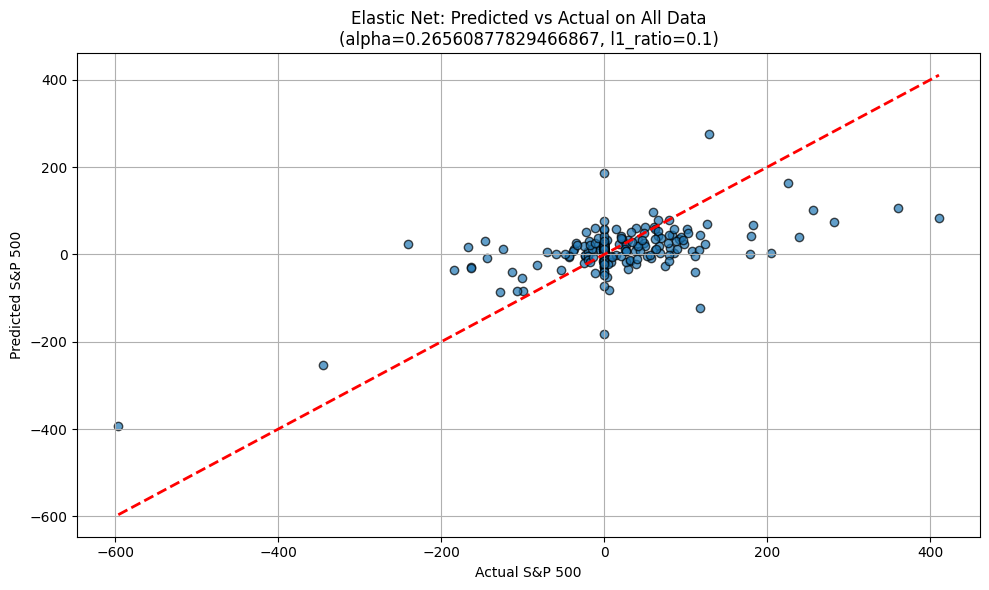

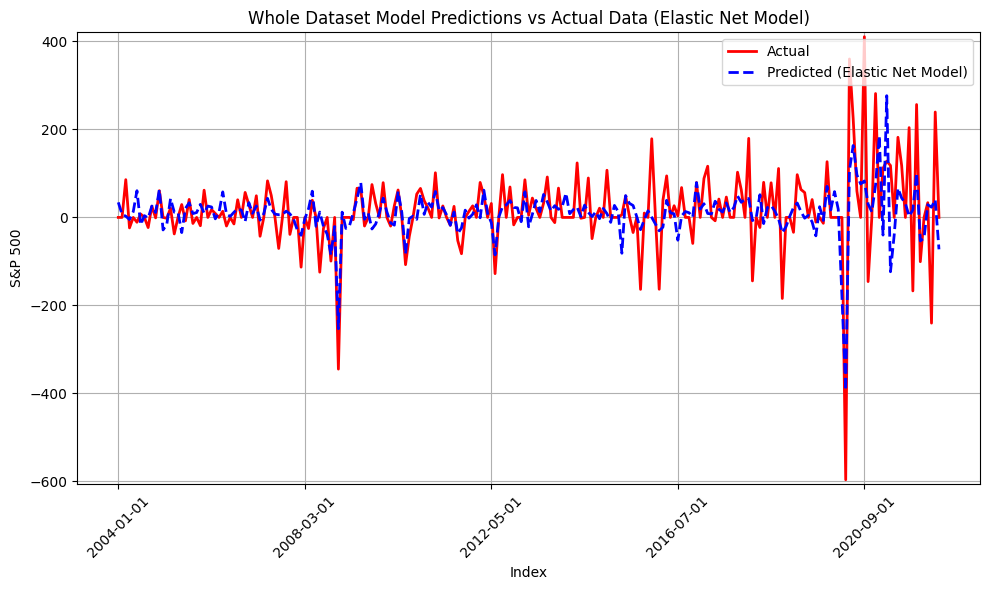

In [ ]:
# Test our best model on the whole dataset including COVID and get MSE and R^2:
X_all = all_data.drop(columns=['sp500'])
y_all = all_data['sp500']
X_all_scaled = scaler.transform(X_all)

elastic_best_lambda = elastic_net_cv.alpha_
elastic_best_l1_ratio = elastic_net_cv.l1_ratio_

y_pred_all = elastic_net_cv.predict(X_all_scaled)
all_elastic_test_mse = mean_squared_error(y_all, y_pred_all)  # MSE
all_elastic_test_r2 = r2_score(y_all, y_pred_all)  # R^2

# Print MSE and R^2
print(f"Elastic Net Model Performance on pre-COVID Data:")
print(f"Mean Squared Error (MSE): {elastic_test_mse:.2f}")
print(f"R^2 Score: {elastic_test_r2:.2f}")

print(f"Elastic Net Model Performance on All Data:")
print(f"Mean Squared Error (MSE): {all_elastic_test_mse:.2f}")
print(f"R^2 Score: {all_elastic_test_r2:.2f}")

# Plot 1: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_all, y_pred_all, alpha=0.7, edgecolor='k')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)
plt.title(f'Elastic Net: Predicted vs Actual on All Data\n(alpha={elastic_best_lambda}, l1_ratio={elastic_best_l1_ratio})')
plt.xlabel('Actual S&P 500')
plt.ylabel('Predicted S&P 500')
plt.grid()
plt.tight_layout()
plt.show()

# Plot 2: Model Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(all_data.index, all_data["sp500"], color='red', linewidth=2, label='Actual')  # Actual data
plt.plot(
    all_data.index,
    y_pred_all,
    color='blue', linewidth=2, linestyle='--', label='Predicted (Elastic Net Model)'
)  # Predictions
plt.xlabel('Index')
plt.ylabel('S&P 500')
plt.ylim(all_data['sp500'].min() - 10, all_data['sp500'].max() + 10)  # Set appropriate y-axis limits
plt.title('Whole Dataset Model Predictions vs Actual Data (Elastic Net Model)')
plt.legend(loc='upper right')
plt.xticks(ticks=all_data.index[::50], rotation=45)  # Show fewer x-axis labels for clarity
plt.grid()
plt.tight_layout()
plt.show()
